# High magnitude flows
## Comparison of observed vs. full natural flows (FNF) vs 40% FNF with FERC
### Author: Kirsten Ondris
***

### Import packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 600
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.pyplot import cm
import dataretrieval.nwis as nwis
from scipy.signal import argrelextrema
from collections import defaultdict
from cdec_scraper import cdec_sensor_data
from datetime import date #for date.today() function

In [2]:
# Convert MAF to km3 and vice versa
MAF_to_km3 = 1e6 * 43560 * 0.0283 * 1e-9
km3_to_MAF = 1 / (1e6 * 43560 * 0.0283 * 1e-9)

## Set parameters

In [3]:
### 1. Select site(s) ###
#sites = [11447650, 11303500] # Sacramento River at Freeport, San Joaquin Basin at Vernalis
# sites = [11447650] # Sacramento River at Freeport
# site = 11447650
#sites = [11303500] # San Joaquin Basin at Vernalis
#site = 11303500
sites = [11289650] # Tuolumne R Bl Lagrange Dam Nr Lagrange CA
site = '11289650' # Tuolumne R Bl Lagrange Dam Nr Lagrange CA
sites = [11290000] # Tuolumne R at Modesto
site = '11290000' # Tuolumne R at Modesto

### 2. Select corresponding site(s) for files ###
#selected_sites = 'SRB_SJB'
#selected_sites = 'Stan_Tuol_Merc'
selected_sites = 'Tuol'

### 3. Select streamflow data type ###
flow_type = 'obs'
#flow_type = 'fnf'
#flow_type = 'fnf_ferc'

### 4. Select date range for streamflow record ###
#start_year = '1929'
start_year = '1993'
start_date = start_year+'-10-01' # '1929-10-01'
#end_date = '2015-04-28' # ending date for Kocis paper
end_date = '2023-09-30' # include most recent 30-year record

### 5. Select corresponding date range for files ###
#selected_record = 'full_rec'
selected_record = '30yr_rec'
#selected_record = 'post-imp'

### 6. Select threshold for HMF ###
selected_threshold = 'p90'
#selected_threshold = '2yr_event'
#selected_threshold = '3yr_event'
#selected_threshold = '5yr_event'
#selected_threshold = '10yr_event'

## Download streamflow data

In [4]:
# Function to clean fnf dataset
def replace_nan_with_avg(series):
    for i in range(len(series)):
        if pd.isna(series[i]):
            before = series[i - 1] if i > 0 and not pd.isna(series[i - 1]) else 0
            after = series[i + 1] if i < len(series) - 1 and not pd.isna(series[i + 1]) else 0
            series[i] = (before + after) / 2
    return series

# Function to grab and clean FNF data
def clean_fnf_data(link):
    df = pd.read_csv(link, index_col=0)
    df = df.mask(df < 0, np.nan) # replace negative values with NaN
    df = df.apply(replace_nan_with_avg) # replace NaN values with average
    df.rename(columns={'TLG_FNF_CFS':'flow_cfs'}, inplace=True)
    df.to_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\fnf_tuol_cdec_CLEAN.csv')
    return df

# Function to grab USGS mean daily streamflow
def grab_usgs_mean_daily_streamflow(site_id, start_date, end_date):
    df = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    return df

# Save observed USGS data for Tuolumne R at LGR
observed_tuol_usgs = grab_usgs_mean_daily_streamflow('11289650', start_date, end_date)
observed_tuol_usgs.to_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\observed_tuol_usgs.csv')
    
# Fucntion to get streamflow data ('daily') for selected flow type
def get_streamflow_data(flow_type):
    for site_id in sites:
        if flow_type == 'obs':
            if site_id == 11447650: # Sacramento River at Freeport daily data stored in two locations by USGS
                #daily = grab_usgs_mean_daily_streamflow(site_id, start_date, end_date)
                discharge_daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end = end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
                #discharge_daily2 = nwis.get_record(sites=str(site_id), service='dv', start='2015-10-01', end=end_date, parameterCd='72137').drop(columns=['72137_Mean_cd', 'site_no']).rename(columns={'72137_Mean': 'flow_cfs'})
                #discharge_daily = pd.concat([daily1, daily2])
            else: # all other gauges store daily data in parameterCd 00060
                discharge_daily = grab_usgs_mean_daily_streamflow(site_id, start_date, end_date)
        elif flow_type == 'fnf':
            discharge_daily = clean_fnf_data('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_raw\\fnf_tuol_cdec.csv')
        else:
            discharge_daily = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\fnf_with_ferc.csv', index_col=0, parse_dates=True)
        #fnf = cdec_sensor_data(cdec_sensor, 8, 'D', sd='1993-10-01', ed='2022-09-30')
        return discharge_daily

discharge_daily = get_streamflow_data('fnf')
discharge_daily.head()

,flow_cfs
datetime,
10/1/1993,525.0
10/2/1993,336.0
10/3/1993,279.5
10/4/1993,223.0
10/5/1993,1118.0


## Streamflow thresholds (e.g., 90th, 2-year event) functions

In [5]:
file_name = 'results/tables/thresholds/'+selected_sites+'/thresholds_flow_'+selected_record+'_'+selected_sites+'_'+flow_type+'.csv'

def calc_p90(df):
    return round(df['flow_cfs'].quantile(0.9), 1) # 90th percentile

def calc_retper_flow(site_id, T):
#     if sites_df.loc[site_id, 'peakData'] == 'y':
#         qpeakDF = nwis.get_record(sites=str(site_id), service='peaks', start=start_date, end=end_date).drop(columns=['agency_cd', 'site_no'])
#         qpeak = qpeakDF['peak_va']
#     else:
#         daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
#         qpeak = daily['flow_cfs'].resample('AS-OCT').max()
#         print(qpeak)
    qpeakDF = nwis.get_record(sites=str(site_id), service='peaks', start=start_date, end=end_date).drop(columns=['agency_cd', 'site_no'])
    qpeak = qpeakDF['peak_va']
    x = qpeak.values
    x[x == 0] = 0.01    
    y = np.log(x)
    m = np.mean(y) # sample mean in LOG SPACE
    s = np.std(y) # sample STD in LOG SPACE
    Zp = stats.norm.ppf(1 - 1/T) # Z-score for 99%; inverse CDF 
    g = stats.skew(y)
    Kp = (2/g)*(1 + g*Zp/6 - g**2/36)**3 - 2/g
    return np.exp(m + Kp*s)

def thresholds_flow(daily):
    df = pd.DataFrame()
    df['sites'] = sites
    df = df.set_index('sites')
    
    p90_list = []
    retper_2yr = []
    retper_3yr = []
    retper_5yr = []
    retper_10yr = []
    
    for site_id in sites:
        p90 = calc_p90(daily)
        p90_list.append(p90)
    
        ret_per = [2, 3, 5, 10]
        for T in ret_per:
            flow = calc_retper_flow(site_id, T)
            if T == 2:
                retper_2yr.append(flow) 
            elif T == 3:
                retper_3yr.append(flow)
            elif T == 5:
                retper_5yr.append(flow)
            else:
                retper_10yr.append(flow)
            
    df['p90'] = p90_list
    df['2yr_event'] = retper_2yr
    df['3yr_event'] = retper_3yr
    df['5yr_event'] = retper_5yr
    df['10yr_event'] = retper_10yr 
    df['flood_DWR'] = 8500 # for Tuolumne R. only
    df = df.round(decimals = 0)
    #thresholds_obs.to_csv(file_name)
    return df

def thresholds_percentiles(discharge_daily, thresholds_flow_df):
    df = pd.DataFrame()
    for site_id in sites:
        pctlList = []
        for threshold in thresholds_flow_df.columns:
            pctl = round((discharge_daily['flow_cfs'] < thresholds_flow_df.loc[site_id, threshold]).mean(), 2)
            pctlList.append(pctl)
        df = df.append(pd.DataFrame([pctlList], columns=thresholds_flow_df.columns), ignore_index=False)
    df['sites'] = sites
    df = df.set_index('sites')
    return df

In [6]:
# # Run functions for each flow type

# flow_types = ['obs', 'fnf', 'fnf_ferc']
# flowDict = {}
# thresholds_flowDict = {}
# thresholds_percentileDict = {}

# for flow_type in flow_types:
#     discharge_daily = get_streamflow_data(flow_type)
#     flowDict[flow_type] = discharge_daily
#     thresholds_flowDict[flow_type] = thresholds_flow(discharge_daily)
#     thresholds_percentileDict[flow_type] = thresholds_percentiles(discharge_daily, thresholds_flowDict[flow_type])
# print('done')

## Flow characteristics functions

In [7]:
# Functions

# Create column with WY 
def add_WY_DOHY(df):
    df['datetime'] = pd.to_datetime(df.index)
    #df.index = df.index.date # reset index to date only (no time)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df['year'] = df['datetime'].dt.strftime('%Y') # create year column 
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear # create column with DOY
    df['DOHY'] = [d - 273 if d >= 274 else d + 91 for d in df['DOY']]
    df.set_index('datetime', inplace=True)
    columns_to_remove = ['month', 'year']
    df = df.drop(columns=columns_to_remove)
    return df
    
def calc_HMF(thresholds_flowDict, flow_type, selected_threshold, df): # HMF = discharge above threshold
    threshold = float(thresholds_flowDict[flow_type][selected_threshold][int(site)])
    FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['HMF_cfs'] = FlowAbvThresholdList
    return df

# Create dataframes of daily flow for selected months
def create_3month_df(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df_new = df[(df.month == '12') | (df.month == '01') | (df.month == '02')]
    columns_to_remove = ['datetime', 'month']
    df = df.drop(columns=columns_to_remove)
    return df_new

def create_4month_df(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df_new = df[(df.month == '12') | (df.month == '01') | (df.month == '02') | (df.month == '03')]
    columns_to_remove = ['datetime', 'month']
    df = df.drop(columns=columns_to_remove)
    return df_new

def create_6month_df(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df_new = df[(df.month == '11') | (df.month == '12') | (df.month == '01') | (df.month == '02') | (df.month == '03') | (df.month == '04')]
    columns_to_remove = ['datetime', 'month']
    df = df.drop(columns=columns_to_remove)
    return df_new

# Magnitude
def calc_mag_maf(df):
    AnnualVolAbvThreshold = df['HMF_cfs'].resample('AS-OCT').sum() * 86400 / 43560 / 1e6 # MAF, total flow above threshold for all years (including non-HMF years)
    #timeseries_annual['mag_maf'][site_id] = AnnualVolAbvThreshold_AllYears
    #AnnualAvgVolAbvThreshold = AnnualVolAbvThreshold_AllYears[AnnualVolAbvThreshold_AllYears != 0].dropna().mean() #MAF/yr, average annual volume above threshold for HMF years only
    #AnnualAvgVolAbvThresholdList.append(AnnualAvgVolAbvThreshold)
    return AnnualVolAbvThreshold # returns list

# Function to sum values above one
def sum_values_above_one(x):
    return sum(1 for flow in x if flow > 0)

# Duration
def calc_dur_days(df):
    DaysAbvThreshold = df['HMF_cfs'].resample('AS-OCT').apply(sum_values_above_one)
    #timeseries_annual_obs['dur_days'][site_id] = DaysAbvThreshold_AllYears
    #AvgDaysAbvThreshold = DaysAbvThreshold_AllYears[DaysAbvThreshold_AllYears != 0].dropna().mean()
    #AnnualAvgDaysAbvThresholdList.append(AvgDaysAbvThreshold)
    return DaysAbvThreshold # return list

# Intra-annual frequency
def calc_intra_ann_fre(df):
    n = 1
    df['max'] = df['HMF_cfs'].iloc[argrelextrema(df['HMF_cfs'].values, np.greater_equal, order=n, mode='clip')[0]]
    PeaksAbvThreshold = df['max'].resample('AS-OCT').apply(sum_values_above_one)
    #timeseries_annual_obs['intra_ann_fre_days'][site_id] = PeaksAbvThreshold_AllYears
    #AvgPeaksAbvThreshold = PeaksAbvThreshold_AllYears[PeaksAbvThreshold_AllYears != 0].dropna().mean()
    #AnnualAvgPeaksAbvThresholdList.append(AvgPeaksAbvThreshold)
    return PeaksAbvThreshold # returns list

# Inter-annual frequency
def calc_inter_ann_fre(df):  
    HMFyears = df.loc[df['HMF_cfs'] != 0].WY.unique() # list of WYs with HMFs
    AllYears = df.WY.unique() # list of all WYs
    HMFyearsList = [1 if year in HMFyears.tolist() else 0 for year in allYears] # list of 0 or 1 for WY without and with HMF
    #timeseries_annual_obs['inter_ann_fre'][site_id] = HMFyearsList
    InterAnnFrequ = round(len(HMFyears) / len(AllYears) * 100, 1)
    #InterAnnFrequList.append(InterAnnFrequ)
    return InterAnnFrequ # returns value

# Timing (center of mass)
def center_of_mass(x):
    num = 0
    den = 0
    for i in range(len(x)):
        num += x[i] * i
        den += x[i]
    return (num/den)

def calc_tim(df):
    COM_list = df['HMF_cfs'].resample('AS-OCT').apply(center_of_mass)
    COM_list = COM_list.fillna(0)
    #timeseries_annual_obs['tim_hdoy'][site_id] = COM_annual
    #COM_mean = COM_annual.mean()
    #AnnualTimingAbvThresholdList.append(COM)
    return COM_list # returns list
    
# Duration of individual events per year
def list_of_consec_days_per_event(x): # x is HMF series
    EventDuration = 0
    List_EventDuration = []
    
    # create list that records 0 for 0 HMF days and records number of consecutive HMF days
    for flow in x:
        EventDuration += 1
        if flow == 0:
            EventDuration = 0
        List_EventDuration.append(EventDuration)
    # create new list of the maximum duration of each event (only records a number that is greater than the previous day 
    # and greater than the next day, since the next day should = 0)
    PeakEventDurationList = [List_EventDuration[i] for i in range(len(List_EventDuration)-1) 
                             if (List_EventDuration[i - 1] < List_EventDuration[i]) and (List_EventDuration[i] > List_EventDuration[i + 1])]
    return PeakEventDurationList
    
def mean_days_per_event(x):
    PeakEventDurationList = list_of_consec_days_per_event(x)
    return np.mean(PeakEventDurationList) # use this for average number of days per event over some time span

def calc_event_duration(df):
    AvgEventDuration = df['HMF_cfs'].resample('AS-OCT').apply(mean_days_per_event)
    AvgEventDuration = AvgEventDuration.fillna(0)
    #timeseries_annual_obs['event_dur_days'][site_id] = AvgEventDuration
    #AvgAnnualEventDuration = AvgEventDuration[AvgEventDuration != 0].dropna().mean()
    #AvgAnnualEventDurationList.append(AvgAnnualEventDuration)
    return AvgEventDuration

# Number of events per year
def mean_number_of_events(x):
    PeakEventDurationList = list_of_consec_days_per_event(x)
    return len(PeakEventDurationList) # use this for average number of events over some time span

def calc_number_of_events(df):
    AvgNumberofEvents = df['HMF_cfs'].resample('AS-OCT').apply(mean_number_of_events)
    #timeseries_annual_obs['event_dur_days'][site_id] = AvgEventDuration
    #AvgAnnualEventDuration = AvgEventDuration[AvgEventDuration != 0].dropna().mean()
    #AvgAnnualEventDurationList.append(AvgAnnualEventDuration)
    return AvgNumberofEvents

def calc_zero_deflated_mean(annual_timeseries):
    avg_metric = annual_timeseries[annual_timeseries != 0].dropna().mean()
    return avg_metric
                              
def create_summary_table(df):
    # Create summary table to store data for each flow characteristic
    cols = [#'mag_maf', 'mag_km3', 'mag_maf_6mo', 'mag_km3_6mo', 'mag_maf_4mo', 'mag_km3_4mo', 'mag_maf_3mo', 'mag_km3_3mo', 'pct_mag_6mo', 'pct_mag_4mo', 'pct_mag_3mo',
            'mag_maf', #'mag_maf_6mo', 'mag_maf_4mo', 'mag_maf_3mo',
            'dur_days', #'dur_days_6mo', 'dur_days_4mo', 'dur_days_3mo',
            'intra_ann_fre', #'intra_ann_fre_6mo', 'intra_ann_fre_4mo', 'intra_ann_fre_3mo',
            #'inter_ann_fre', 'intra_ann_fre_6mo', 'intra_ann_fre_4mo', 'intra_ann_fre_3mo',
            'tim_dohy',
            'event_fre', #'event_fre_6mo', 'event_fre_4mo', 'event_fre_3mo'
            'event_dur'
            ]
    
    rows = ['count','mean','std','min','25%','50%','75%','max']
    
    summary = pd.DataFrame(columns=cols, index=rows)
    
    data = pd.DataFrame({'mag_maf': calc_mag_maf(df), #'mag_maf_6mo': AnnualVolAbvThreshold_AllYears_6mo, 'mag_maf_4mo': AnnualVolAbvThreshold_AllYears_4mo, 'mag_maf_3mo': AnnualVolAbvThreshold_AllYears_3mo,
                        'dur_days': calc_dur_days(df), #'dur_days_6mo': DaysAbvThreshold_AllYears_6mo, 'dur_days_4mo': DaysAbvThreshold_AllYears_4mo, 'dur_days_3mo': DaysAbvThreshold_AllYears_3mo,
                        'intra_ann_fre': calc_intra_ann_fre(df), #'intra_ann_fre_6mo': PeaksAbvThreshold_AllYears_6mo, 'intra_ann_fre_4mo': PeaksAbvThreshold_AllYears_4mo, 'intra_ann_fre_3mo': PeaksAbvThreshold_AllYears_3mo,
                        #'inter_ann_fre': calc_inter_ann_fre(df), 'inter_ann_fre_6mo': PeaksAbvThreshold_AllYears_6mo, 'inter_ann_fre_4mo': PeaksAbvThreshold_AllYears_4mo, 'inter_ann_fre_3mo': PeaksAbvThreshold_AllYears_3mo,
                        'tim_dohy': calc_tim(df),
                        'event_fre': calc_number_of_events(df), #'event_fre_6mo': AvgEventDuration_6mo, 'event_fre_4mo': AvgEventDuration_4mo, 'event_fre_3mo': AvgEventDuration_3mo,
                        'event_dur': calc_event_duration(df), #'event_dur_6mo': AvgEventDuration_6mo, 'event_dur_4mo': AvgEventDuration_4mo, 'event_dur_3mo': AvgEventDuration_3mo
                            })
    for j in cols:
            #print(j)
            summary.loc['count',j] = data[data[j] != 0][j].size
            summary.loc['mean',j] = np.mean(data[data[j] != 0][j])
            summary.loc['std',j] = np.std(data[data[j] != 0][j])
            summary.loc['min',j] = np.amin(data[data[j] != 0][j])
            summary.loc['25%',j] = np.quantile(data[data[j] != 0][j], 0.25)
            summary.loc['50%',j] = np.quantile(data[data[j] != 0][j], 0.5)
            summary.loc['75%',j] = np.quantile(data[data[j] != 0][j], 0.75)
            summary.loc['max',j] = np.amax(data[data[j] != 0][j])
            
    return data, summary
#summary.to_csv(file_name)
    

#file_name = 'results/tables/flow_char/'+selected_sites+'/summary_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'_'+flow_type+'.csv'

In [8]:
# Generate df for each flow type

flow_types = ['obs', 'fnf', 'fnf_ferc']
flowDict = {}
thresholds_flowDict = {}
thresholds_percentileDict = {}

for flow_type in flow_types:
    discharge_daily = get_streamflow_data(flow_type)
    #flowDict[flow_type] = discharge_daily
    thresholds_flowDict[flow_type] = thresholds_flow(discharge_daily)
    thresholds_percentileDict[flow_type] = thresholds_percentiles(discharge_daily, thresholds_flowDict[flow_type])
    discharge_daily = add_WY_DOHY(discharge_daily)
    discharge_daily = calc_HMF(thresholds_flowDict, 'obs', selected_threshold, discharge_daily)
    #discharge_daily = calc_HMF(thresholds_flowDict['obs'], selected_threshold, discharge_daily) ########### use 'obs' or flow_type for thresholds_flowDict ??????? 
    flowDict[flow_type] = discharge_daily
    flowDict[flow_type+'_3mo'] = create_3month_df(discharge_daily)
    flowDict[flow_type+'_4mo'] = create_4month_df(discharge_daily) 
    flowDict[flow_type+'_6mo'] = create_6month_df(discharge_daily) 

print('done')

done


In [9]:
thresholds_flowDict

{'obs':              p90  2yr_event  3yr_event  5yr_event  10yr_event  flood_DWR
 sites                                                                   
 11290000  4550.0     3818.0     5748.0     8761.0     14246.0       8500,
 'fnf':              p90  2yr_event  3yr_event  5yr_event  10yr_event  flood_DWR
 sites                                                                   
 11290000  7528.0     3818.0     5748.0     8761.0     14246.0       8500,
 'fnf_ferc':              p90  2yr_event  3yr_event  5yr_event  10yr_event  flood_DWR
 sites                                                                   
 11290000  2718.0     3818.0     5748.0     8761.0     14246.0       8500}

### Timeseries plots of observed v. FNF v. FERC flows

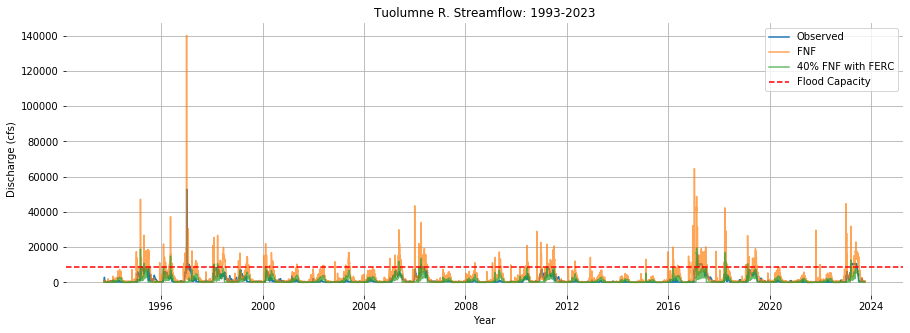

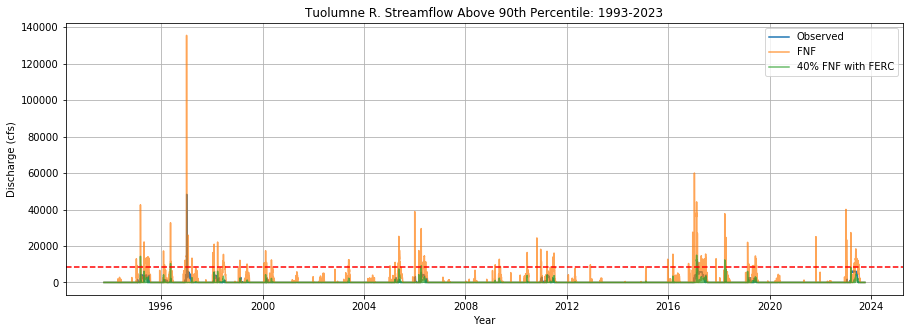

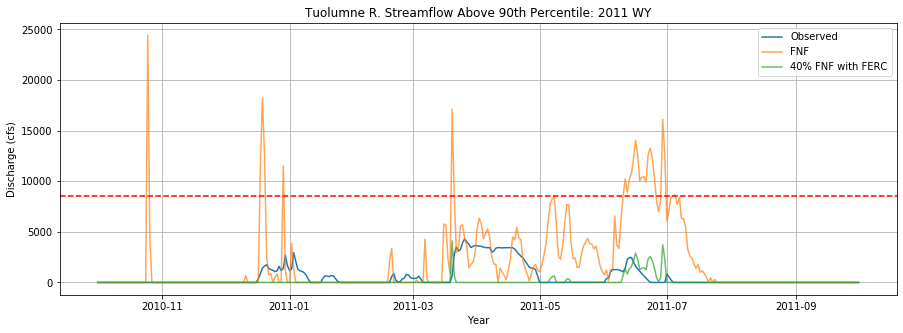

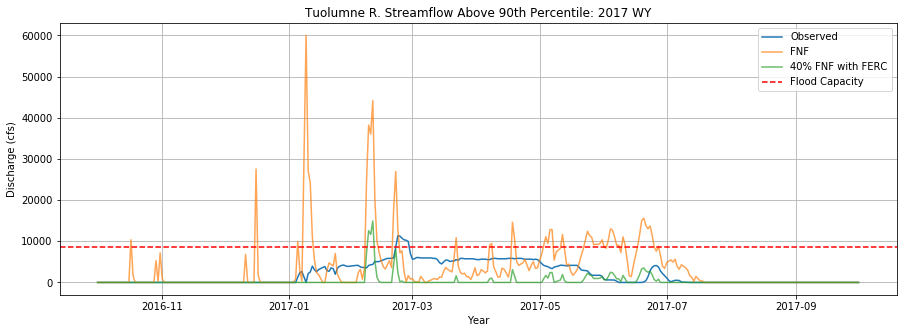

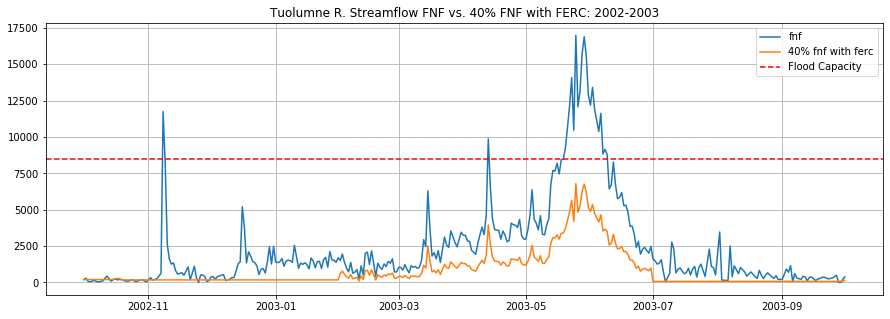

In [10]:
labels = ['Observed', 'FNF', '40% FNF with FERC']
alpha_values = [1, 0.7, 0.7]
fig, ax = plt.subplots(figsize=(15,5))
for i, flow_type in enumerate(flow_types):
    ax.plot(flowDict[flow_type]['flow_cfs'], label=labels[i], alpha=alpha_values[i])
    ax.set_xlabel('Year')
    ax.set_ylabel('Discharge (cfs)')
    ax.set_label('Flow (cfs)')
    ax.set_title('Tuolumne R. Streamflow: 1993-2023')
ax.axhline(y=8500, color='r', linestyle='--', label='Flood Capacity')
ax.legend()
plt.grid()
# Remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_daily_flows_1993_2022_'+selected_record+'_'+flow_type+'_'+str(site)+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(15,5))
for i, flow_type in enumerate(flow_types):
    ax.plot(flowDict[flow_type]['HMF_cfs'], label= labels[i], alpha=alpha_values[i])
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Discharge (cfs)')
    ax.set_label('Flow (cfs)')
    ax.set_title('Tuolumne R. Streamflow Above 90th Percentile: 1993-2023')
ax.axhline(y=8500, color='r', linestyle='--', label='Flood Capacity')
plt.grid()
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_HMF_flows_1993_2022_'+selected_record+'_'+flow_type+'_'+str(site)+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

start_period = '10-01-2010'
end_period = '10-01-2011'
fig, ax = plt.subplots(figsize=(15,5)) 
for i, flow_type in enumerate(flow_types):
    ax.plot(flowDict[flow_type]['HMF_cfs'][start_period:end_period], label= labels[i], alpha=alpha_values[i])
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Discharge (cfs)')
    ax.set_label('Flow (cfs)')
    ax.set_title('Tuolumne R. Streamflow Above 90th Percentile: 2011 WY')
ax.axhline(y=8500, color='r', linestyle='--', label='Flood Capacity')
plt.grid()
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_HMF_flows_2010_2011_'+selected_record+'_'+flow_type+'_'+str(site)+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

start_period = '10-01-2016'
end_period = '10-01-2017'
fig, ax = plt.subplots(figsize=(15,5))
for i, flow_type in enumerate(flow_types):
    ax.plot(flowDict[flow_type]['HMF_cfs'][start_period:end_period], label= labels[i], alpha=alpha_values[i])
    ax.set_xlabel('Year')
    ax.set_ylabel('Discharge (cfs)')
    ax.set_label('Flow (cfs)')
    ax.set_title('Tuolumne R. Streamflow Above 90th Percentile: 2017 WY')
ax.axhline(y=8500, color='r', linestyle='--', label='Flood Capacity')
ax.legend()
plt.grid()
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_HMF_flows_2016_2017_'+selected_record+'_'+flow_type+'_'+str(site)+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

# Check fnf vs. fnf_ferc
start_period = '10-01-2002'
end_period = '10-01-2003'
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(flowDict['fnf']['flow_cfs'][start_period:end_period], label='fnf')
ax.plot(flowDict['fnf_ferc']['flow_cfs'][start_period:end_period], label='40% fnf with ferc')
ax.axhline(y=8500, color='r', linestyle='--', label='Flood Capacity')
ax.legend()
plt.title('Tuolumne R. Streamflow FNF vs. 40% FNF with FERC: 2002-2003')
plt.grid()
plt.show()

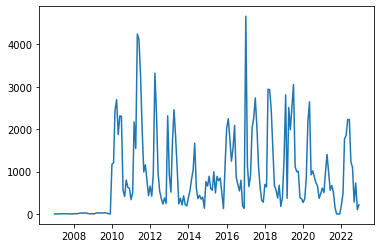

In [11]:
# Add water rights data
cfs_to_maf = 60 * 60 * 24 / 43560 / 1e6
# diversions_annual = pd.read_excel('../water_rights_ewrims/tuol_river_wr.xlsx', sheet_name='Diversions_annual', index_col=0)#, parse_dates=True)
# diversions_annual_sum = diversions_annual.sum(axis=1) / 1E6 / cfs_to_maf / 365
# diversions_annual_sum = diversions_annual_sum.to_frame(name='flow_cfs')
# diversions_annual_sum['datetime'] = pd.to_datetime(diversions_annual_sum.index.astype(str) + '-10-01')
# diversions_annual_sum.set_index('datetime', inplace=True)
# diversions_annual_sum

# Upload excel file
diversions_monthly = pd.read_excel('../water_rights_ewrims/tuol_river_wr_monthly.xlsx', sheet_name='Diversions_monthly')#, parse_dates=True)

# Set datetime index to year, month, day columns
diversions_monthly['datetime'] = pd.to_datetime(diversions_monthly[['year', 'month', 'day']])
diversions_monthly.set_index('datetime', inplace=True)
diversions_monthly = diversions_monthly.drop(['year', 'month', 'day'], axis='columns')

# Convert flow from AF/month to cfs
diversions_monthly['flow_cfs'] = diversions_monthly['all_holders_AF'] / 1E6 / cfs_to_maf / 30

# Order dates to plot correctly
diversions_monthly.sort_values(by='datetime', inplace = True)
#diversions_monthly

plt.plot(diversions_monthly['flow_cfs'])
#plt.fill_between(x=diversions_monthly['flow_cfs'].index, y1=0, y2=diversions_monthly['flow_cfs'], color='coral', label='Water Rights Allocations', alpha=0.6)

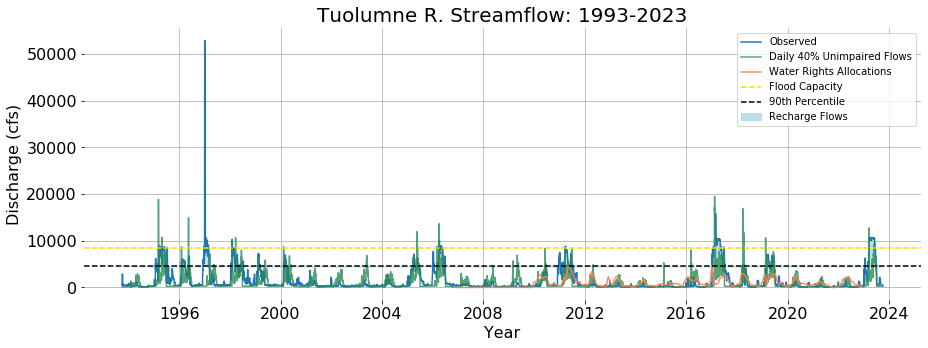

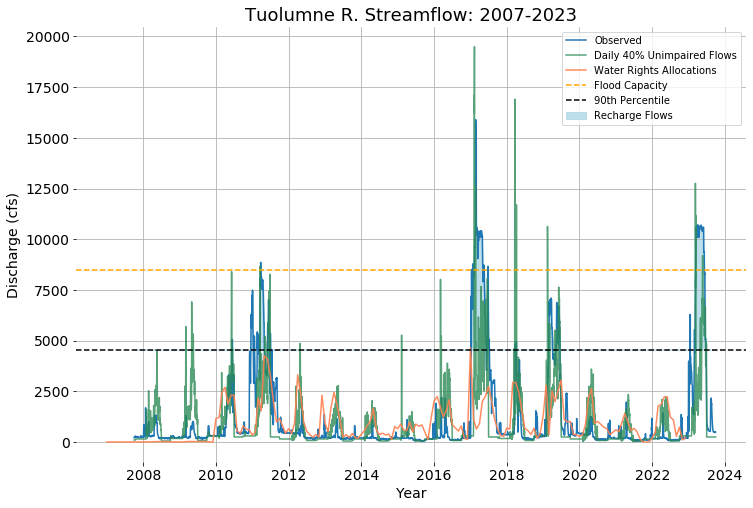

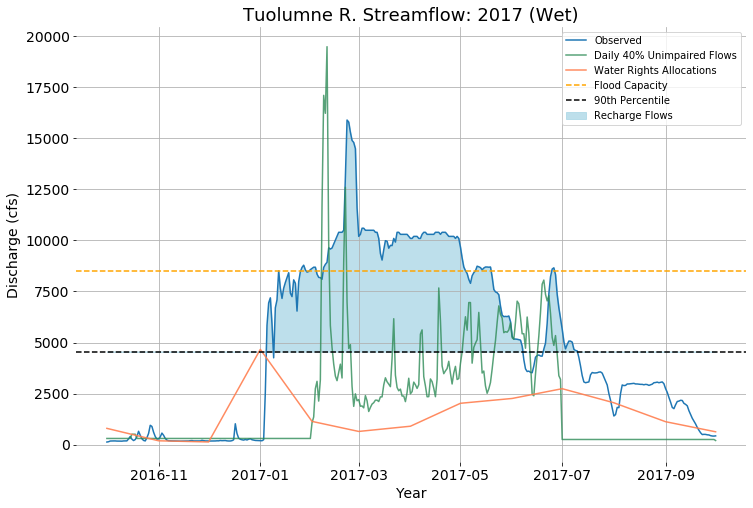

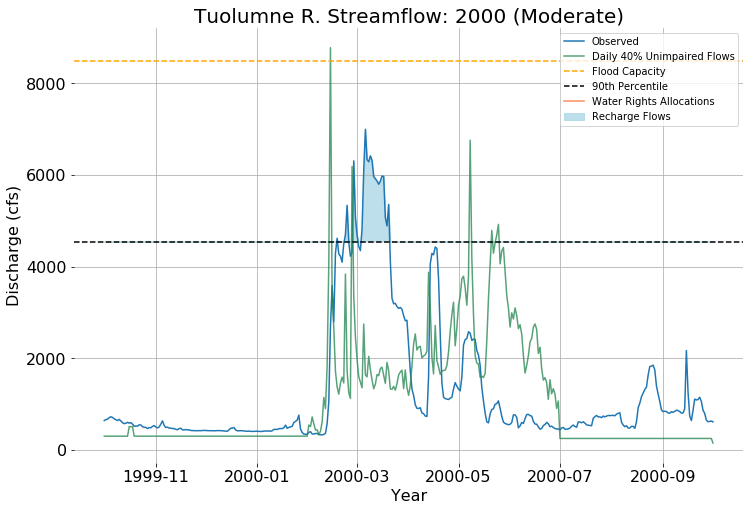

In [12]:
# Hydrograph of 30 years for observed, recharge, unimpaired, and water rights flows

flowDict['obs']['HMF_cfs_plot'] = flowDict['obs']['HMF_cfs'] + thresholds_flowDict['obs'][selected_threshold][int(site)]

#### All years: 1993-2023 #####
#flow_types = ['obs', 'fnf_ferc']
#labels = ['Observed', 'Daily 40% Unimpaired Flows']
alpha_values = [1, 0.7]
fig, ax = plt.subplots(figsize=(15,5))
    
ax.plot(flowDict['obs']['flow_cfs'], label='Observed', alpha=1)
ax.fill_between(x=flowDict['obs'].index, y1=thresholds_flowDict['obs'][selected_threshold][int(site)], y2= flowDict['obs']['HMF_cfs_plot'], 
                color='lightblue', alpha=0.8, label='Recharge Flows')
ax.plot(flowDict['fnf_ferc']['flow_cfs'], color='seagreen', label='Daily 40% Unimpaired Flows', alpha=0.8)
ax.plot(diversions_monthly['flow_cfs'], color='coral', label='Water Rights Allocations', alpha=0.9)
#ax.fill_between(x=diversions_monthly['flow_cfs'].index, y1=0, y2=diversions_monthly['flow_cfs'], color='coral', label='Water Rights Allocations', alpha=0.6)

ax.axhline(y=8500, color='gold', linestyle='--', label='Flood Capacity')
ax.axhline(y=thresholds_flowDict['obs'][selected_threshold][int(site)], color='black', linestyle='--', label='90th Percentile')

ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Discharge (cfs)', fontsize=16)
ax.set_title('Tuolumne R. Streamflow: 1993-2023', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.legend()
plt.grid()

# Remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_daily_flows_1993_2023.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

##########################################################################################
####Years with water rights data: 2007-2023 #####
start_period = '10-01-2007'
end_period = '10-01-2023'
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(flowDict['obs']['flow_cfs'][start_period:end_period], label='Observed', alpha=1)
ax.fill_between(x=flowDict['obs'][start_period:end_period].index, y1=thresholds_flowDict['obs'][selected_threshold][int(site)], y2= flowDict['obs']['HMF_cfs_plot'][start_period:end_period], 
                color='lightblue', alpha=0.8, label='Recharge Flows')
ax.plot(flowDict['fnf_ferc']['flow_cfs'][start_period:end_period], color='seagreen', label='Daily 40% Unimpaired Flows', alpha=0.8)
ax.plot(diversions_monthly['flow_cfs'], color='coral', label='Water Rights Allocations', alpha=0.9)
#ax.fill_between(x=diversions_monthly['flow_cfs'].index, y1=0, y2=diversions_monthly['flow_cfs'], color='coral', label='Water Rights Allocations', alpha=0.6)

ax.axhline(y=8500, color='orange', linestyle='--', label='Flood Capacity')
ax.axhline(y=thresholds_flowDict['obs'][selected_threshold][int(site)], color='black', linestyle='--', label='90th Percentile')

# for i, flow_type in enumerate(flow_types):
#     ax.plot(flowDict[flow_type]['HMF_cfs'][start_period:end_period], label= labels[i], alpha=alpha_values[i])
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Discharge (cfs)')
#     ax.set_label('Flow (cfs)')
#     ax.set_title('Tuolumne R. Streamflow Above 90th Percentile: 2017 WY')

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Discharge (cfs)', fontsize=14)
ax.set_title('Tuolumne R. Streamflow: 2007-2023', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

# Remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend()
plt.grid()
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_HMF_flows_2007_2023.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

######################################################################################
#### Annual plot: 2017 ####
year = '2017'
start_period = '10-01-'+str(int(year)-1)
end_period = '10-01-'+year
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(flowDict['obs']['flow_cfs'][start_period:end_period], label='Observed', alpha=1)
ax.fill_between(x=flowDict['obs'][start_period:end_period].index, y1=thresholds_flowDict['obs'][selected_threshold][int(site)], y2= flowDict['obs']['HMF_cfs_plot'][start_period:end_period], 
                color='lightblue', alpha=0.8, label='Recharge Flows')
ax.plot(flowDict['fnf_ferc']['flow_cfs'][start_period:end_period], color='seagreen', label='Daily 40% Unimpaired Flows', alpha=0.8)
ax.plot(diversions_monthly['flow_cfs'][start_period:end_period], color='coral', label='Water Rights Allocations', alpha=0.9)

ax.axhline(y=8500, color='orange', linestyle='--', label='Flood Capacity')
ax.axhline(y=thresholds_flowDict['obs'][selected_threshold][int(site)], color='black', linestyle='--', label='90th Percentile')

# for i, flow_type in enumerate(flow_types):
#     ax.plot(flowDict[flow_type]['HMF_cfs'][start_period:end_period], label= labels[i], alpha=alpha_values[i])
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Discharge (cfs)')
#     ax.set_label('Flow (cfs)')
#     ax.set_title('Tuolumne R. Streamflow Above 90th Percentile: 2017 WY')

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Discharge (cfs)', fontsize=14)
ax.set_title(f'Tuolumne R. Streamflow: {year} (Wet)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

# Remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend()
plt.grid()
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_HMF_flows_'+year+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

##########################################################################
#### Annual plot: 2018 ####
year = '2000'
start_period = '10-01-'+str(int(year)-1)
end_period = '10-01-'+year
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(flowDict['obs']['flow_cfs'][start_period:end_period], label='Observed', alpha=1)
ax.fill_between(x=flowDict['obs'][start_period:end_period].index, y1=thresholds_flowDict['obs'][selected_threshold][int(site)], y2= flowDict['obs']['HMF_cfs_plot'][start_period:end_period], 
                color='lightblue', alpha=0.8, label='Recharge Flows')
ax.plot(flowDict['fnf_ferc']['flow_cfs'][start_period:end_period], color='seagreen', label='Daily 40% Unimpaired Flows', alpha=0.8)

ax.axhline(y=8500, color='orange', linestyle='--', label='Flood Capacity')
ax.axhline(y=thresholds_flowDict['obs'][selected_threshold][int(site)], color='black', linestyle='--', label='90th Percentile')
ax.plot(diversions_monthly['flow_cfs'][start_period:end_period], color='coral', label='Water Rights Allocations', alpha=0.9)

# for i, flow_type in enumerate(flow_types):
#     ax.plot(flowDict[flow_type]['HMF_cfs'][start_period:end_period], label= labels[i], alpha=alpha_values[i])
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Discharge (cfs)')
#     ax.set_label('Flow (cfs)')
#     ax.set_title('Tuolumne R. Streamflow Above 90th Percentile: 2017 WY')

ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Discharge (cfs)', fontsize=16)
ax.set_title(f'Tuolumne R. Streamflow: {year} (Moderate)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

# Remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend()
plt.grid()
file_name = '../results/figures/timeseries/streamflow/'+selected_sites+'/compare_HMF_flows_'+year+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

In [13]:
flowDict['obs']['HMF_cfs_plot'] = flowDict['obs']['HMF_cfs'] + thresholds_flowDict['obs'][selected_threshold][int(site)]

In [14]:
thresholds_flowDict

{'obs':              p90  2yr_event  3yr_event  5yr_event  10yr_event  flood_DWR
 sites                                                                   
 11290000  4550.0     3818.0     5748.0     8761.0     14246.0       8500,
 'fnf':              p90  2yr_event  3yr_event  5yr_event  10yr_event  flood_DWR
 sites                                                                   
 11290000  7528.0     3818.0     5748.0     8761.0     14246.0       8500,
 'fnf_ferc':              p90  2yr_event  3yr_event  5yr_event  10yr_event  flood_DWR
 sites                                                                   
 11290000  2718.0     3818.0     5748.0     8761.0     14246.0       8500}

### Calculate annual flow statistics

In [15]:
# Create data and summary dfs for each flow type

#for flow_type in flow_types:
data_obs, summary_obs = create_summary_table(flowDict['obs'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_obs_fullyear.csv'
summary_obs.to_csv(file_name)

data_obs_3mo, summary_obs_3mo = create_summary_table(flowDict['obs_3mo'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_obs_3mo.csv'
summary_obs_3mo.to_csv(file_name)

data_obs_4mo, summary_obs_4mo = create_summary_table(flowDict['obs_4mo'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_obs_4mo.csv'
summary_obs_4mo.to_csv(file_name)

data_obs_6mo, summary_obs_6mo = create_summary_table(flowDict['obs_6mo'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_obs_6mo.csv'
summary_obs_6mo.to_csv(file_name)

data_fnf, summary_fnf = create_summary_table(flowDict['fnf'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_fnf_fullyear.csv'
summary_fnf.to_csv(file_name)

data_fnf_4mo, summary_fnf_4mo = create_summary_table(flowDict['fnf_4mo'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_fnf_4mo.csv'
summary_fnf_4mo.to_csv(file_name)

data_fnf_ferc, summary_fnf_ferc = create_summary_table(flowDict['fnf_ferc'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_fnf_ferc_fullyear.csv'
summary_fnf_ferc.to_csv(file_name)

data_fnf_ferc_4mo, summary_fnf_ferc_4mo = create_summary_table(flowDict['fnf_ferc_4mo'])
file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_fnf_ferc_4mo.csv'
summary_fnf_ferc_4mo.to_csv(file_name)

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kondr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kondr\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# Test outputs
#summary_fnf
#data_obs
flowDict['obs']

,flow_cfs,WY,DOY,DOHY,HMF_cfs,datetime,month,HMF_cfs_plot,max
datetime,,,,,,,,,
1993-10-01 00:00:00+00:00,569.0,1994,274,1,0.0,1993-10-01 00:00:00+00:00,10,4550.0,0.0
1993-10-02 00:00:00+00:00,586.0,1994,275,2,0.0,1993-10-02 00:00:00+00:00,10,4550.0,0.0
1993-10-03 00:00:00+00:00,575.0,1994,276,3,0.0,1993-10-03 00:00:00+00:00,10,4550.0,0.0
1993-10-04 00:00:00+00:00,511.0,1994,277,4,0.0,1993-10-04 00:00:00+00:00,10,4550.0,0.0
1993-10-05 00:00:00+00:00,583.0,1994,278,5,0.0,1993-10-05 00:00:00+00:00,10,4550.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-09-26 00:00:00+00:00,477.0,2023,269,360,0.0,2023-09-26 00:00:00+00:00,09,4550.0,0.0
2023-09-27 00:00:00+00:00,484.0,2023,270,361,0.0,2023-09-27 00:00:00+00:00,09,4550.0,0.0
2023-09-28 00:00:00+00:00,484.0,2023,271,362,0.0,2023-09-28 00:00:00+00:00,09,4550.0,0.0


### Box plots comparing flow characteristics

Full year versus Dec-Apr for Observed Flows

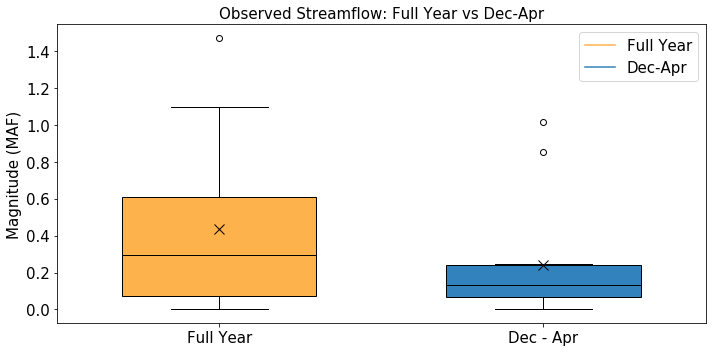

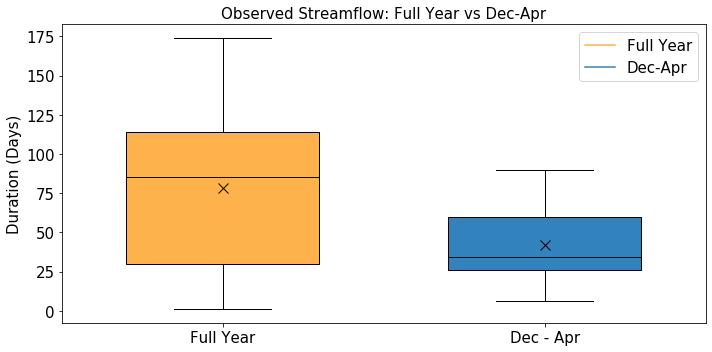

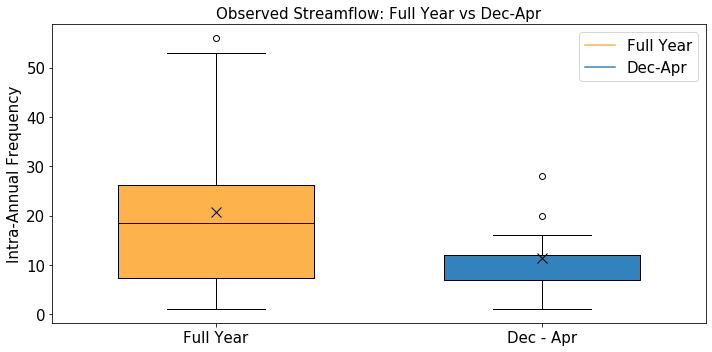

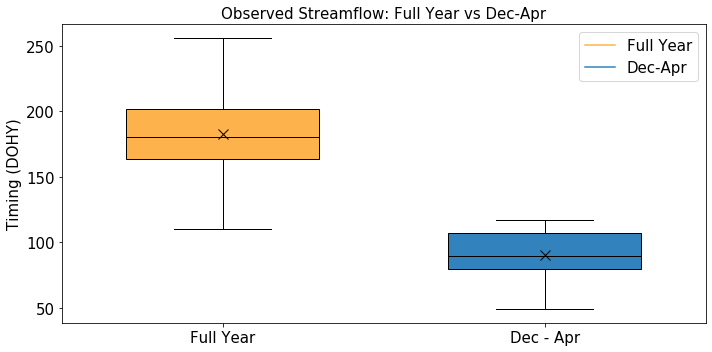

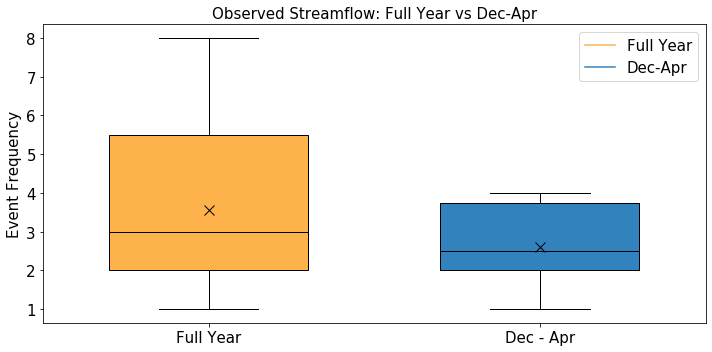

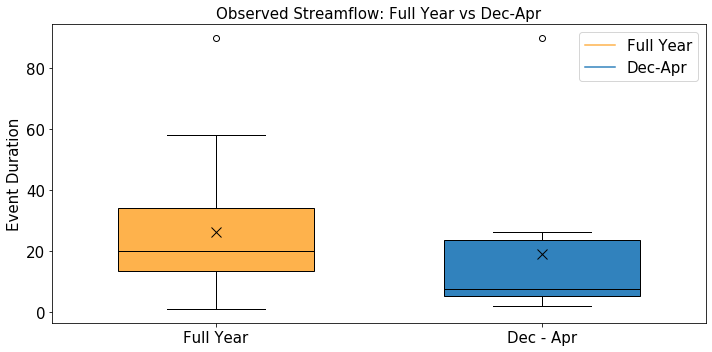

In [17]:
# Boxplots of flow characteristics for observed flows (full year vs. Dec-Apr)

ticks = ['Full Year','Dec - Apr']
cols = ['mag_maf', 'dur_days', 'intra_ann_fre', 'tim_dohy', 'event_fre', 'event_dur']
yaxes = ['Magnitude (MAF)', 'Duration (Days)', 'Intra-Annual Frequency', 'Timing (DOHY)', 'Event Frequency', 'Event Duration']

for i, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.boxplot(data_obs[data_obs[col] != 0][col], positions=[-1], widths=0.6, patch_artist=True, 
            boxprops=dict(facecolor='#feb24c'), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    ax.boxplot(data_obs_4mo[data_obs_4mo[col] != 0][col], positions=[0], widths=0.6, patch_artist=True, #[col+'_4mo']
            boxprops=dict(facecolor='#3182bd'), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    # draw temporary red and blue lines and use them to create a legend
    ax.plot([], c='#feb24c', label='Full Year')
    ax.plot([], c='#3182bd', label='Dec-Apr')
    ax.legend(loc=1, prop={"size":15})

    # customize plot
    plt.xticks([-1,0], ticks, fontsize=15)
    #ax.set_xticks([-1,0], ticks)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel(yaxes[i], fontsize=15)
    #plt.xlim(-2, len(ticks)*3)
    #plt.ylim(0, 1)
    plt.title('Observed Streamflow: Full Year vs Dec-Apr', fontsize=15)
    plt.tight_layout()
    
    file_name = f'../results/figures/box_plots/tuol_compare_obs_flows_{col}.png'
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()

Observed v. FNF v. FERC flows

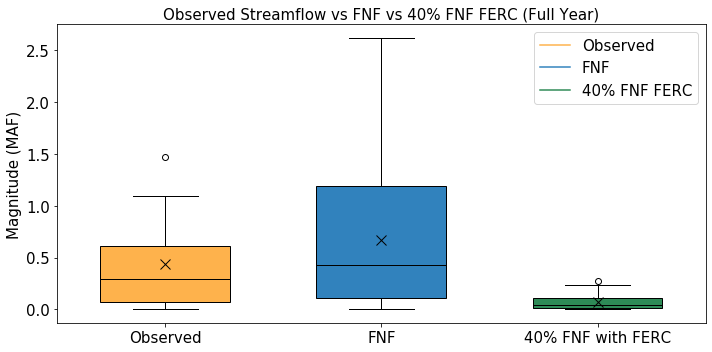

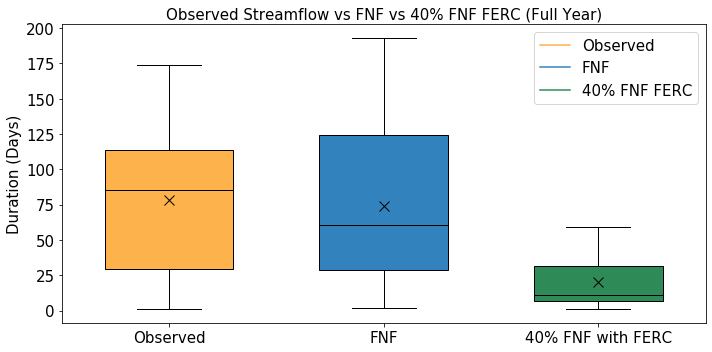

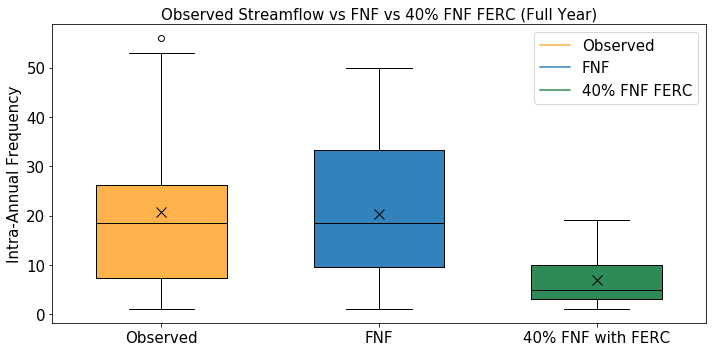

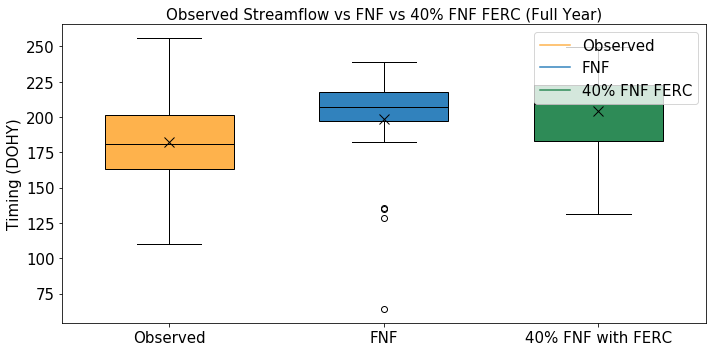

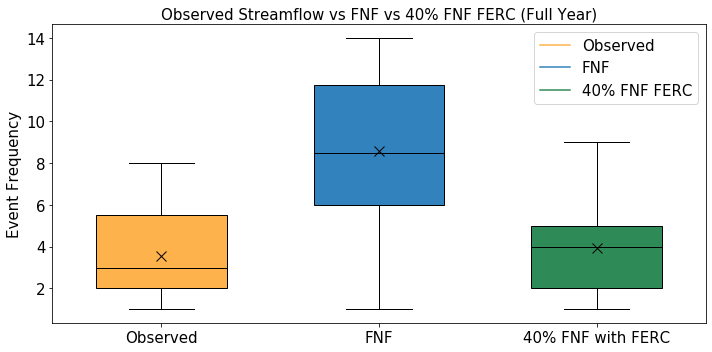

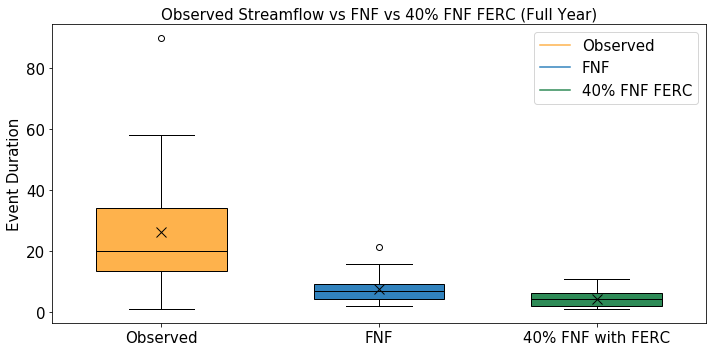

In [18]:
# Boxplots of flow characteristics for observed vs. fnf vs. ferc flows (full year)

ticks = ['Observed','FNF', "40% FNF with FERC"]
cols = ['mag_maf', 'dur_days', 'intra_ann_fre', 'tim_dohy', 'event_fre', 'event_dur']
yaxes = ['Magnitude (MAF)', 'Duration (Days)', 'Intra-Annual Frequency', 'Timing (DOHY)', 'Event Frequency', 'Event Duration']

for i, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.boxplot(data_obs[data_obs[col] != 0][col], positions=[-1], widths=0.6, patch_artist=True, 
            boxprops=dict(facecolor='#feb24c'), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    ax.boxplot(data_fnf[data_fnf[col] != 0][col], positions=[0], widths=0.6, patch_artist=True, #[col+'_4mo']
            boxprops=dict(facecolor='#3182bd'), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
    
    ax.boxplot(data_fnf_ferc[data_fnf_ferc[col] != 0][col], positions=[1], widths=0.6, patch_artist=True, #[col+'_4mo']
            boxprops=dict(facecolor='seagreen'), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    # draw temporary red and blue lines and use them to create a legend
    ax.plot([], c='#feb24c', label='Observed')
    ax.plot([], c='#3182bd', label='FNF')
    ax.plot([], c='seagreen', label='40% FNF FERC')
    ax.legend(loc=1, prop={"size":15})

    # customize plot
    plt.xticks([-1,0, 1], ticks, fontsize=15)
    #ax.set_xticks([-1,0], ticks)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel(yaxes[i], fontsize=15)
    #plt.xlim(-2, len(ticks)*3)
    #plt.ylim(0, 1)
    plt.title('Observed Streamflow vs FNF vs 40% FNF FERC (Full Year)', fontsize=15)
    plt.tight_layout()
    
    file_name = f'../results/figures/box_plots/tuol_compare_flows_{col}.png'
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()

### Timeseries plots of observed v. FNF v. FERC flows

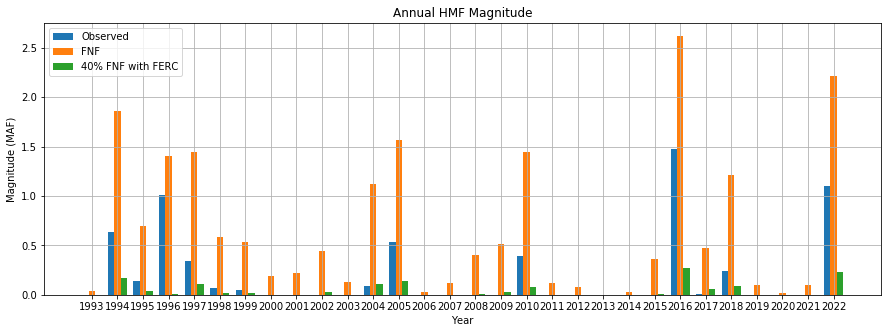

In [19]:
# Plot of average HMF magnitude by year

# Convert the 'date' column to a datetime object if it's not already
data_obs['date'] = pd.to_datetime(data_obs.index)
data_fnf['date'] = pd.to_datetime(data_fnf.index)
data_fnf_ferc['date'] = pd.to_datetime(data_fnf_ferc.index)

# Extract the year from the 'date' column
data_obs['year'] = data_obs['date'].dt.year
data_fnf['year'] = data_fnf['date'].dt.year
data_fnf_ferc['year'] = data_fnf_ferc['date'].dt.year

# Group the data by 'year' and calculate the mean of 'mag_maf' for each year
yearly_data_obs = data_obs.groupby('year')['mag_maf'].sum()
yearly_data_fnf = data_fnf.groupby('year')['mag_maf'].sum()
yearly_data_fnf_ferc = data_fnf_ferc.groupby('year')['mag_maf'].sum()

# Create categories for the x-axis
categories = data_fnf['year'].to_list()

# Create bar plot
x = np.arange(len(categories)) # Create an array of x positions for the bars
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(15,5))

plt.grid()
bar1 = ax.bar(x - width, yearly_data_obs, width, label='Observed')
bar2 = ax.bar(x, yearly_data_fnf, width, label='FNF')
bar3 = ax.bar(x + width, yearly_data_fnf_ferc, width, label='40% FNF with FERC')

ax.set_xlabel('Year')
ax.set_ylabel('Magnitude (MAF)')
ax.set_title('Annual HMF Magnitude')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
file_name = '../results/figures/bar_plots/'+selected_sites+'/annual_HMF_flows_'+str(site)+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

# # Plot of average HMF magnitude by month

# # Group the data by 'year' and calculate the mean of 'mag_maf' for each year
# monthly_flow_obs = flowDict['obs'].groupby('month')['mag_maf'].mean()
# monthly_flow_fnf = flowDict['fnf'].groupby('month')['mag_maf'].mean()
# monthly_flow_fnf_ferc = flowDict['fnf_ferc'].groupby('month')['mag_maf'].mean()

# # Create categories for the x-axis
# categories = flowDict['obs']['month'].unique()

# # Create bar plot
# x = np.arange(len(categories)) # Create an array of x positions for the bars
# width = 0.25  # Width of the bars

# fig, ax = plt.subplots(figsize=(15,5))

# plt.grid()
# bar1 = ax.bar(x - width, monthly_flow_obs, width, label='Observed')
# bar2 = ax.bar(x, monthly_flow_fnf, width, label='FNF')
# bar3 = ax.bar(x + width, monthly_flow_fnf_ferc, width, label='40% FNF with FERC')

# ax.set_xlabel('Year')
# ax.set_ylabel('Magnitude (MAF)')
# ax.set_title('Annual HMF Magnitude')
# ax.set_xticks(x)
# ax.set_xticklabels(categories)
# ax.legend()
# file_name = '../results/figures/bar_plots/'+selected_sites+'/monthly_HMF_flows_'+str(site)+'.png'
# plt.savefig(file_name, bbox_inches="tight")
# plt.show()

In [20]:
yearly_data_obs

year
1993    0.000000
1994    0.632707
1995    0.137058
1996    1.013375
1997    0.342486
1998    0.064701
1999    0.051709
2000    0.000000
2001    0.000000
2002    0.000000
2003    0.000000
2004    0.092192
2005    0.539405
2006    0.000000
2007    0.000000
2008    0.000000
2009    0.001012
2010    0.392588
2011    0.000000
2012    0.000000
2013    0.000000
2014    0.000000
2015    0.000000
2016    1.470823
2017    0.004126
2018    0.243888
2019    0.000000
2020    0.000000
2021    0.000000
2022    1.097137
Name: mag_maf, dtype: float64

In [21]:
flowDict['obs'][flowDict['obs']['month'].isin(['02', '03', '04', '05'])]

,flow_cfs,WY,DOY,DOHY,HMF_cfs,datetime,month,HMF_cfs_plot,max
datetime,,,,,,,,,
1994-02-01 00:00:00+00:00,395.0,1994,32,123,0.0,1994-02-01 00:00:00+00:00,02,4550.0,0.0
1994-02-02 00:00:00+00:00,393.0,1994,33,124,0.0,1994-02-02 00:00:00+00:00,02,4550.0,0.0
1994-02-03 00:00:00+00:00,391.0,1994,34,125,0.0,1994-02-03 00:00:00+00:00,02,4550.0,0.0
1994-02-04 00:00:00+00:00,392.0,1994,35,126,0.0,1994-02-04 00:00:00+00:00,02,4550.0,0.0
1994-02-05 00:00:00+00:00,393.0,1994,36,127,0.0,1994-02-05 00:00:00+00:00,02,4550.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-27 00:00:00+00:00,10500.0,2023,147,238,5950.0,2023-05-27 00:00:00+00:00,05,10500.0,5950.0
2023-05-28 00:00:00+00:00,10500.0,2023,148,239,5950.0,2023-05-28 00:00:00+00:00,05,10500.0,NaN
2023-05-29 00:00:00+00:00,10600.0,2023,149,240,6050.0,2023-05-29 00:00:00+00:00,05,10600.0,6050.0


No handles with labels found to put in legend.


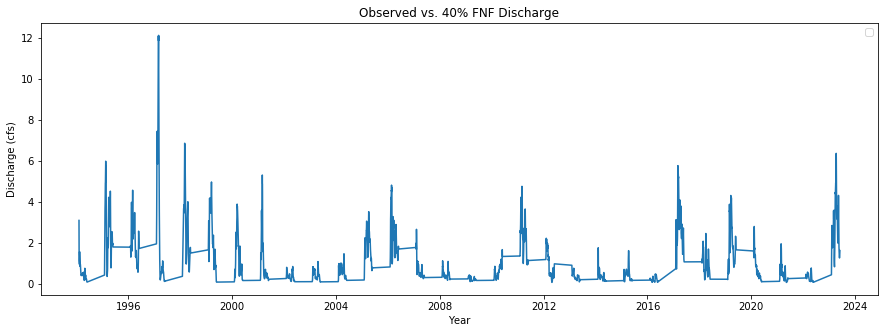

In [22]:
# Plot of obs HMF compared to 40% FNF during May through June

# Group the data by 'year' and calculate the mean of 'mag_maf' for each year
# AnnualVolAbvThreshold = df['HMF_cfs'].resample('AS-OCT').sum() * 86400 / 43560 / 1e6 # MAF
obs_daily_02_to_06 = flowDict['obs'][flowDict['obs']['month'].isin(['02', '03', '04', '05'])]
obs_daily_rolling_7day_avg = obs_daily_02_to_06['flow_cfs'].rolling(window=7).mean()
#data_obs.groupby('year')['mag_maf'].sum() # annual amount of flow available for recharge from February through June

fnf_daily_02_to_06 = flowDict['fnf'][flowDict['fnf']['month'].isin(['02', '03', '04', '05'])]
fnf_daily_rolling_7day_avg = fnf_daily_02_to_06['flow_cfs'].rolling(window=7).mean()
fnf40_daily_rolling_7day_avg = 0.4 * fnf_daily_rolling_7day_avg

#obs_daily_rolling_7day_avg.index = obs_daily_rolling_7day_avg.index.tz_localize('UTC')
#fnf40_daily_rolling_7day_avg.index = tz_convert(obs_daily_rolling_7day_avg.index.tz)
list1 = list(obs_daily_rolling_7day_avg.dropna())
list2 = list(fnf40_daily_rolling_7day_avg.dropna())
percent_obs_of_40fnf = [a / b for a, b in zip(list1, list2)]
percent_obs_of_40fnf = pd.DataFrame({'Pct_diff': percent_obs_of_40fnf}, index=fnf40_daily_rolling_7day_avg.dropna().index)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(percent_obs_of_40fnf)
#ax.plot(obs_daily_rolling_7day_avg, label='Observed')
#ax.plot(fnf40_daily_rolling_7day_avg, label='40% FNF')
ax.set_xlabel('Year')
ax.set_ylabel('Discharge (cfs)')
ax.set_title('Observed vs. 40% FNF Discharge')
ax.legend()
file_name = '../results/figures/bar_plots/'+selected_sites+'/annual_HMF_flows_'+str(site)+'.png'
plt.savefig(file_name, bbox_inches="tight")
plt.show()

In [23]:
len(percent_obs_of_40fnf)

3601

In [24]:
#list(obs_daily_rolling_7day_avg.dropna())

In [25]:
fnf40_daily_rolling_7day_avg

datetime
1994-02-01            NaN
1994-02-02            NaN
1994-02-03            NaN
1994-02-04            NaN
1994-02-05            NaN
                 ...     
2023-05-27    7938.800000
2023-05-28    7617.028571
2023-05-29    7160.228571
2023-05-30    6765.314286
2023-05-31    6435.085714
Name: flow_cfs, Length: 3607, dtype: float64

In [26]:
fnf40_daily_rolling_7day_avg[0:10]

datetime
1994-02-01           NaN
1994-02-02           NaN
1994-02-03           NaN
1994-02-04           NaN
1994-02-05           NaN
1994-02-06           NaN
1994-02-07    127.314286
1994-02-08    261.714286
1994-02-09    442.742857
1994-02-10    494.742857
Name: flow_cfs, dtype: float64

### Water Year Type Comparison

In [27]:
# Create dataframes for WY types
water_year_indices_SVI = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_raw\\water_year_indices_SVI.csv', index_col=0, parse_dates=True)
water_year_indices_SJI = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_raw\\water_year_indices_SJI.csv', index_col=0, parse_dates=True)
WY_SVI = pd.DataFrame(water_year_indices_SVI['WY_type']['1948-01-01':'2023-01-01'])
WY_SJI = pd.DataFrame(water_year_indices_SJI['WY_type']['1923-01-01':'2023-01-01'])

WY_SVI['WY'] = pd.to_datetime(WY_SVI.index)
WY_SJI['WY'] = pd.to_datetime(WY_SJI.index)
WY_SVI['WY'] = WY_SVI['WY'].dt.strftime('%Y')
WY_SJI['WY'] = WY_SJI['WY'].dt.strftime('%Y')
WY_SVI.index.name = 'Date'
WY_SJI.index.name = 'Date'

HMFyrDict = {}
year_types = ['W', 'AN', 'BN', 'D', 'C']
pctHMFbyWY = pd.DataFrame()
nmbrHMFbyWY = pd.DataFrame()
totalnmbryr = pd.DataFrame()

for year_type in year_types:
    
    PctYearWithHMFList = []
    NmbrYearWithHMFList = []
    TotalNmbrYearList = []
    
    for flow_type in flow_types:
        discharge_daily = flowDict[flow_type]
        HMFyears = discharge_daily.loc[discharge_daily['HMF_cfs'] != 0].WY.unique()
        start_year_site = discharge_daily.WY[0]
        
        NmbrYearWithHMF = 0
        PctYearWithHMF = 0
        TotalNmbrYear = 0
        noHMFyrs = 0
        
        for year in WY_SJI.loc[WY_SJI['WY_type'] == year_type]['WY'][start_year_site+'-01-01':]:
            if year in HMFyears:
                #HMFyrDict
                pass
            else:
                #print(yearType, site_id, year)
                noHMFyrs += 1
        PctYearWithHMF = (len(WY_SJI.loc[WY_SJI['WY_type'] == year_type]['WY'][start_year_site+'-01-01':]) - noHMFyrs) / (len(WY_SJI.loc[WY_SJI['WY_type'] == year_type]['WY'][start_year+'-01-01':])) * 100
        PctYearWithHMFList.append(PctYearWithHMF)
        TotalNmbrYear = len(WY_SJI.loc[WY_SJI['WY_type'] == year_type]['WY'][start_year_site+'-01-01':])
        TotalNmbrYearList.append(TotalNmbrYear)
        NmbrYearWithHMF = len(WY_SJI.loc[WY_SJI['WY_type'] == year_type]['WY'][start_year_site+'-01-01':]) - noHMFyrs
        NmbrYearWithHMFList.append(NmbrYearWithHMF)
        
    pctHMFbyWY[year_type] = PctYearWithHMFList
    nmbrHMFbyWY[year_type] = NmbrYearWithHMFList
    totalnmbryr[year_type] = TotalNmbrYearList

nmbrHMFbyWY['flow_type'] = flow_types
nmbrHMFbyWY = nmbrHMFbyWY.set_index('flow_type')
nmbrHMFbyWY['All'] = nmbrHMFbyWY[list(nmbrHMFbyWY.columns)].sum(axis=1)
#nmbrHMFbyWY.to_csv('results/tables/WY/Tuol/nmbrHMFbyWY_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.csv')
print(nmbrHMFbyWY)

totalnmbryr['flow_type'] = flow_types
totalnmbryr = totalnmbryr.set_index('flow_type')
totalnmbryr['All'] = totalnmbryr[list(totalnmbryr.columns)].sum(axis=1)
#totalnmbryr.to_csv('results/tables/WY/Tuol/totalnmbryear_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.csv')
print(totalnmbryr)

pctHMFbyWY['flow_type'] = flow_types
pctHMFbyWY = pctHMFbyWY.set_index('flow_type')
pctHMFbyWY['All'] = nmbrHMFbyWY['All'] / totalnmbryr['All'] * 100
#pctHMFbyWY.to_csv('results/tables/WY/Tuol/pctHMFbyWY_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.csv')
print(pctHMFbyWY)

            W  AN  BN  D  C  All
flow_type                       
obs        10   3   1  0  0   14
fnf        10   3   3  6  8   30
fnf_ferc   10   3   3  2  1   19
            W  AN  BN  D  C  All
flow_type                       
obs        10   3   3  6  8   30
fnf        10   3   3  6  8   30
fnf_ferc   10   3   3  6  8   30
                   W     AN          BN           D      C         All
flow_type                                                             
obs        90.909091  100.0   33.333333    0.000000    0.0   46.666667
fnf        90.909091  100.0  100.000000  100.000000  100.0  100.000000
fnf_ferc   90.909091  100.0  100.000000   33.333333   12.5   63.333333


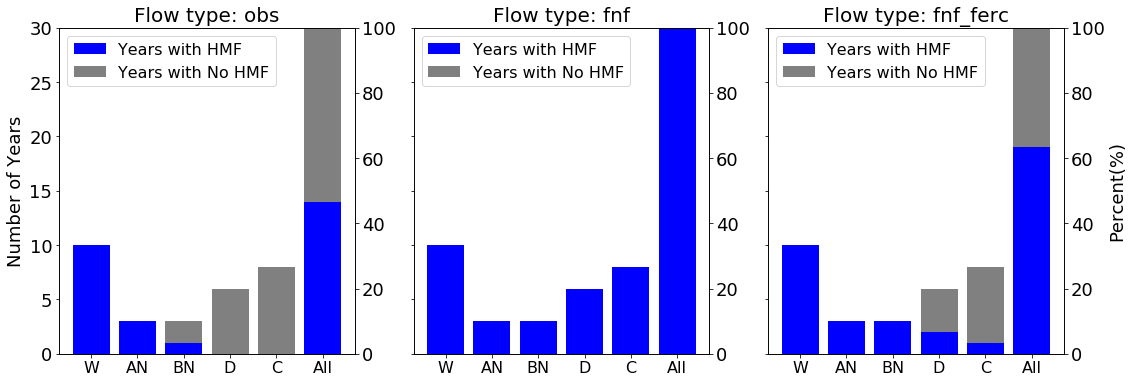

In [28]:
# Bar plots of years with HMF
nmbrHMFbyWY_trans = nmbrHMFbyWY.transpose()
totalnmbryr_trans = totalnmbryr.transpose()
pctHMFbyWY_trans = pctHMFbyWY.transpose()
labels=['W', 'AN', 'BN', 'D', 'C', 'All']
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey = True)
for i, flow_type in enumerate(flow_types):
    flow_df = pd.DataFrame()
    flow_df['HMFyr'] = nmbrHMFbyWY_trans[flow_type]
    flow_df['noHMFyr'] = totalnmbryr_trans[flow_type] - nmbrHMFbyWY_trans[flow_type]
    ax[i].bar(labels, flow_df['HMFyr'], color='blue')
    ax[i].bar(labels, flow_df['noHMFyr'], bottom = flow_df['HMFyr'], color='grey')
    #sns.barplot(x=sites, y=yearType, data=df_test, ax=ax)
    #ax = df_test.plot(kind='bar', stacked=True, title='%s: Number of Years with HMFs' %site_id)
    #ax[i].set_ylabel('Number of Years')
    #plt.ylabel('Number of Years')
    ax[i].set_xticklabels(labels=['W', 'AN', 'BN', 'D', 'C', 'All'], rotation=0, fontsize=16)
    #ax[i].set_yticklabels(fontsize=16)
    ax[i].legend(['Years with HMF', 'Years with No HMF'], fontsize=16)
    ax[i].set_title('Flow type: %s' %flow_type, fontsize=20)
    ax[i].set_ylim(0, 30)
    ax2=ax[i].twinx()
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelsize=18)
ax[0].set_ylabel('Number of Years', fontsize=18)
ax[0].tick_params(axis='y', labelsize=18)
ax2.set_ylabel('Percent(%)', fontsize=18)
#plt.savefig('results/figures/WY/Tuol/years_with_HMF_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

In [29]:
# data_obs = add_WY_DOHY(data_obs)
# data_obs = data_obs.merge(WY_SJI, on='WY', how='left', left_index=True)
# data_obs

flow_data_list = [data_obs, data_fnf, data_fnf_ferc]
for flow_data in flow_data_list:
    flow_data = add_WY_DOHY(flow_data)
    #flow_data = flow_data.merge(WY_SJI, on='WY', how='left', left_index=True)

data_obs = data_obs.merge(WY_SJI, on='WY', how='left', left_index=True)
data_fnf = data_fnf.merge(WY_SJI, on='WY', how='left', left_index=True)
data_fnf_ferc = data_fnf_ferc.merge(WY_SJI, on='WY', how='left', left_index=True)

In [30]:
data_obs

,mag_maf,dur_days,intra_ann_fre,tim_dohy,event_fre,event_dur,date,year,month,WY,DOY,DOHY,WY_type
Date,,,,,,,,,,,,,
1994-01-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,1993-10-01 00:00:00+00:00,1993,10,1994,274,1,C
1995-01-01,0.632707,130.0,24.0,213.900404,6.0,21.666667,1994-10-01 00:00:00+00:00,1994,10,1995,274,1,W
1996-01-01,0.137058,64.0,13.0,167.117656,3.0,21.333333,1995-10-01 00:00:00+00:00,1995,10,1996,274,1,W
1997-01-01,1.013375,90.0,20.0,109.910239,1.0,90.000000,1996-10-01 00:00:00+00:00,1996,10,1997,275,2,W
1998-01-01,0.342486,108.0,32.0,162.119071,8.0,13.500000,1997-10-01 00:00:00+00:00,1997,10,1998,274,1,W
1999-01-01,0.064701,26.0,6.0,140.305641,3.0,8.666667,1998-10-01 00:00:00+00:00,1998,10,1999,274,1,AN
2000-01-01,0.051709,23.0,7.0,160.314154,4.0,5.750000,1999-10-01 00:00:00+00:00,1999,10,2000,274,1,AN
2001-01-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,2000-10-01 00:00:00+00:00,2000,10,2001,275,2,D
2002-01-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,2001-10-01 00:00:00+00:00,2001,10,2002,274,1,D


In [31]:
flowDict_list = [data_obs, data_fnf, data_fnf_ferc]
for flow_data in flowDict_list:
    flow_data = add_WY_DOHY(flow_data)
    #flow_data = flow_data.merge(WY_SJI, on='WY', how='left', left_index=True)

flowDict['obs'] = flowDict['obs'].merge(WY_SJI, on='WY', how='left', left_index=True)
flowDict['fnf'] = flowDict['fnf'].merge(WY_SJI, on='WY', how='left', left_index=True)
flowDict['fnf_ferc'] = flowDict['fnf_ferc'].merge(WY_SJI, on='WY', how='left', left_index=True)

In [32]:
# data_obs, summary_obs = create_summary_table(flowDict['obs'])
# file_name = '../results/tables/flow_char/summary/'+str(site)+'_'+selected_threshold+'_'+selected_record+'_obs_fullyear.csv'
# summary_obs.to_csv(file_name)

In [33]:
# Create dataframes and calculate flow metrics for specific water year types
data_obs_WY = {}
WY_types = ['W', 'AN', 'BN', 'D', 'C']
for WY_type in WY_types:
    data_obs_WY[WY_type] = data_obs[data_obs['WY_type'] == WY_type]
    
flowDict_WY = {}
WY_types = ['W', 'AN', 'BN', 'D', 'C']
for flow_type in flow_types:
     # Initialize a sub-dictionary for the current flow_type
    flowDict_WY[flow_type] = {}
    for WY_type in WY_types:
        flowDict_WY[flow_type][WY_type] = flowDict[flow_type][flowDict[flow_type]['WY_type'] == WY_type]
    
#         testlist = []
#         if site_id == 11447650:
#             for year in WY_SVI.loc[WY_SVI['Yr_type'] == yearType]['WY'][start_year+'-01-01':]:
#                 testlist.append(year)
#             daily_WY = daily[daily['WY'].isin(testlist)] 
#         else:
#             for year in WY_SJI.loc[WY_SJI['Yr_type'] == yearType]['WY'][start_year+'-01-01':]:
#                 testlist.append(year)
#             daily_WY = daily[daily['WY'].isin(testlist)] 

#         #plt.plot(daily['flow_cfs'])
#         plt.plot(daily_WY['flow_cfs'])


#     # Select WET YEARS only
#     if site_id == 11447650:
#         daily = daily[daily['WY'].isin(WY_SVI.loc[WY_SVI['Yr_type'] == yearType]['WY'])]
#     else:
#         daily = daily[daily['WY'].isin(WY_SJI.loc[WY_SJI['Yr_type'] == yearType]['WY'])]

In [34]:
flowDict_WY = {}
WY_types = ['W', 'AN', 'BN', 'D', 'C']
for flow_type in flow_types:
     # Initialize a sub-dictionary for the current flow_type
    flowDict_WY[flow_type] = {}
    
    for WY_type in WY_types:
        flowDict_WY[flow_type][WY_type] = flowDict[flow_type][flowDict[flow_type]['WY_type'] == WY_type]
        
#flowDict_WY

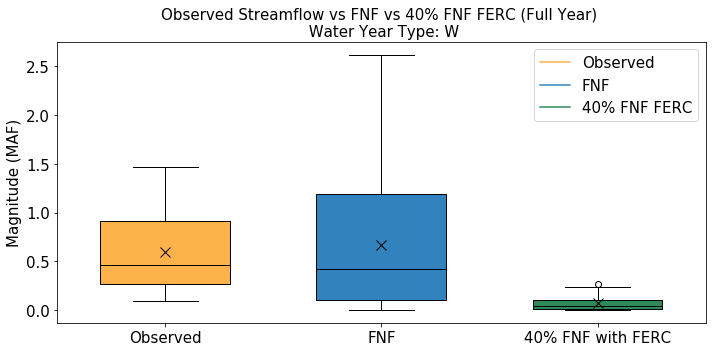

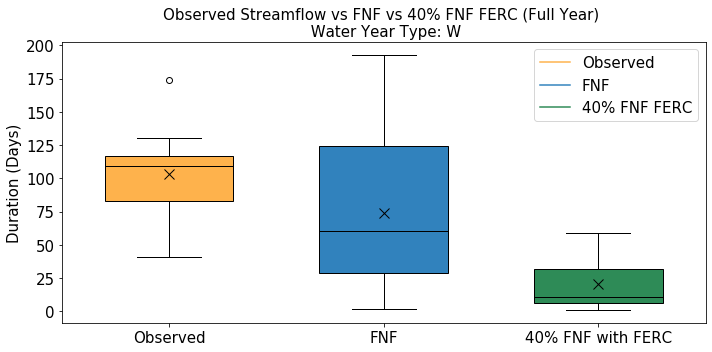

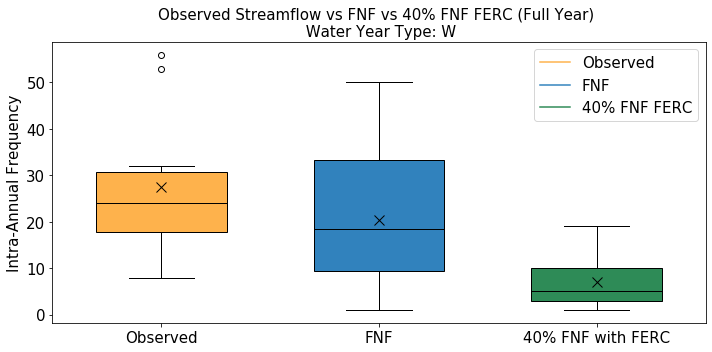

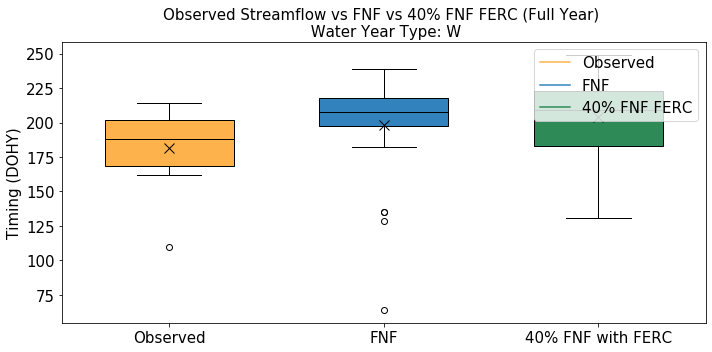

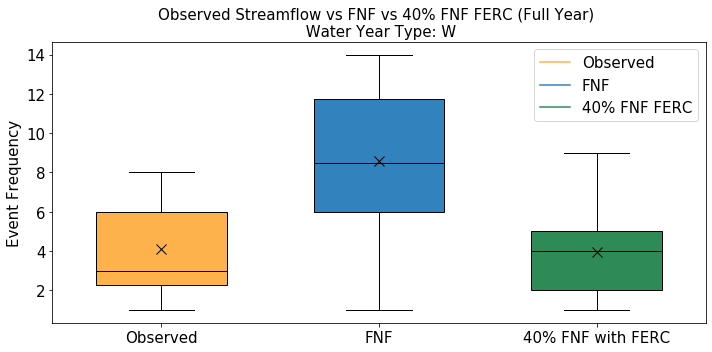

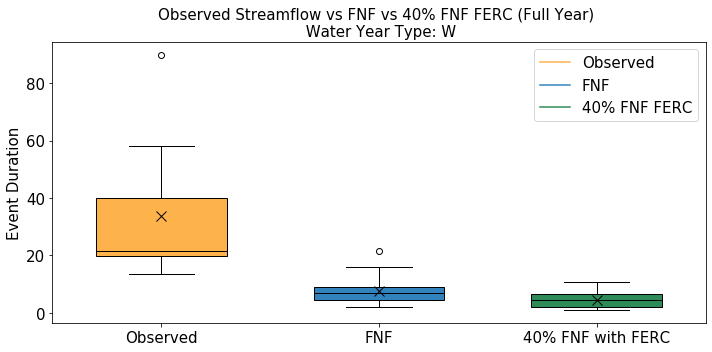

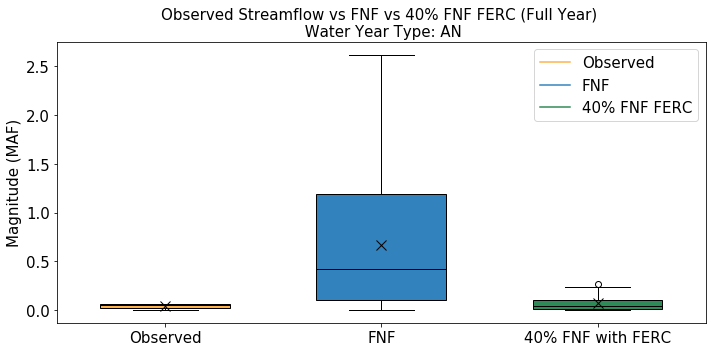

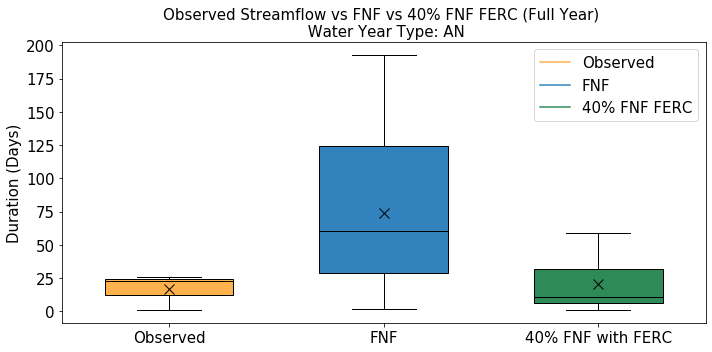

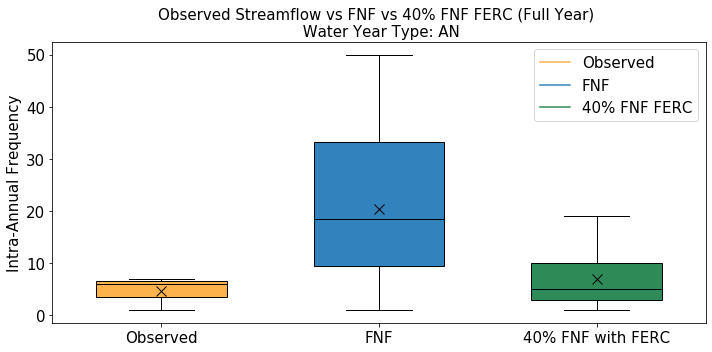

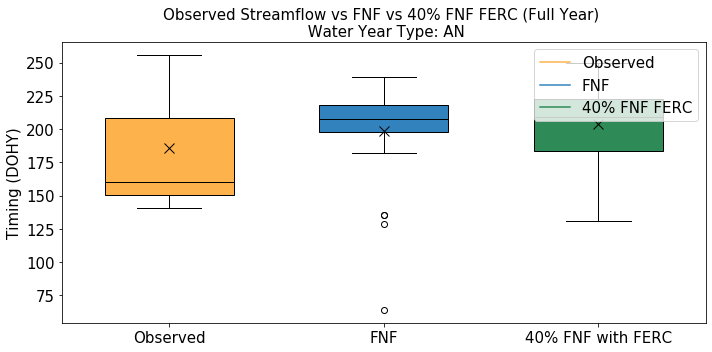

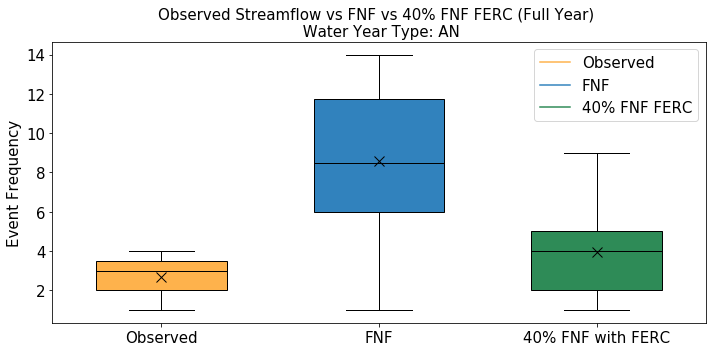

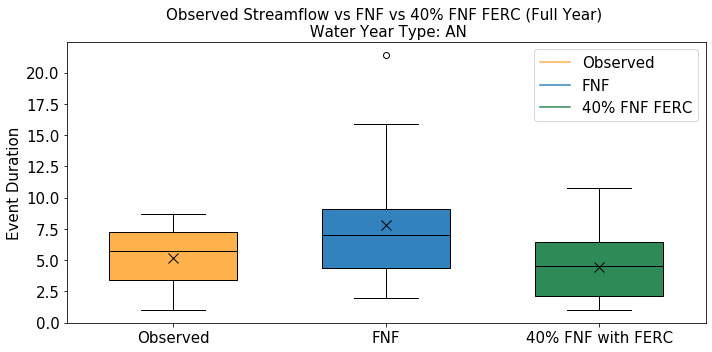

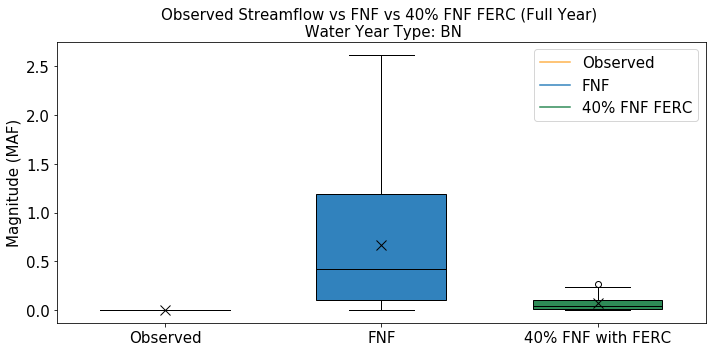

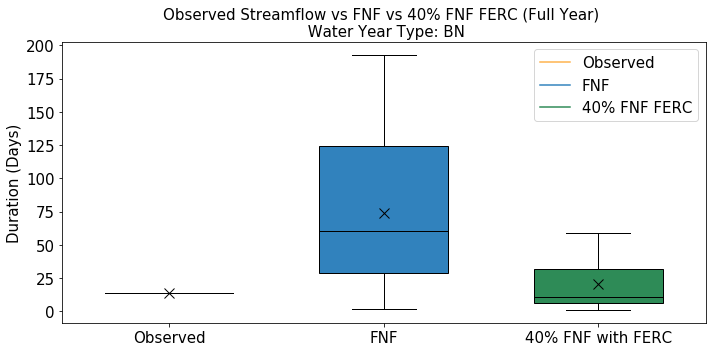

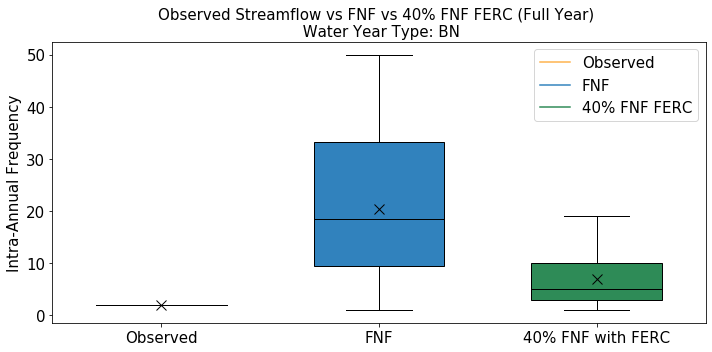

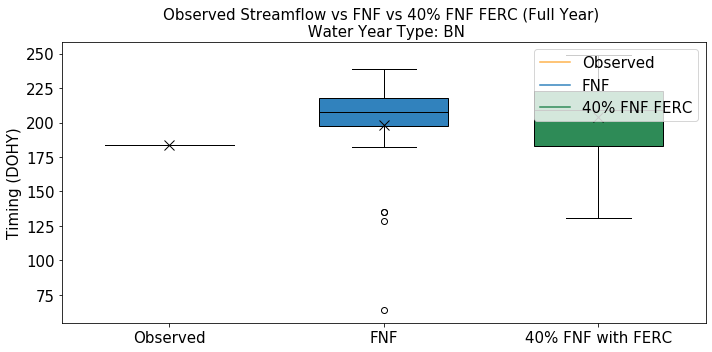

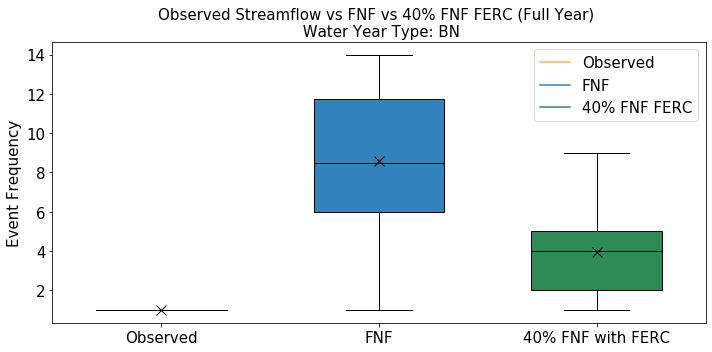

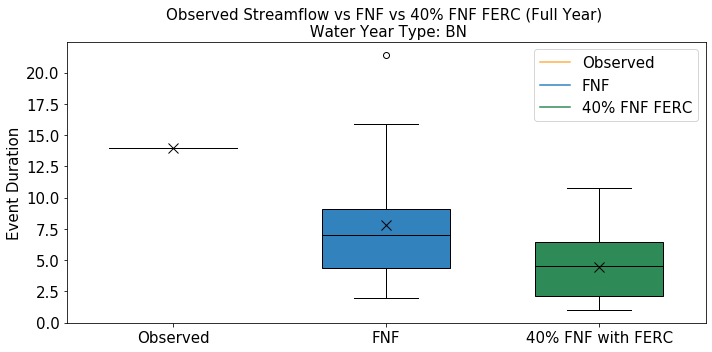

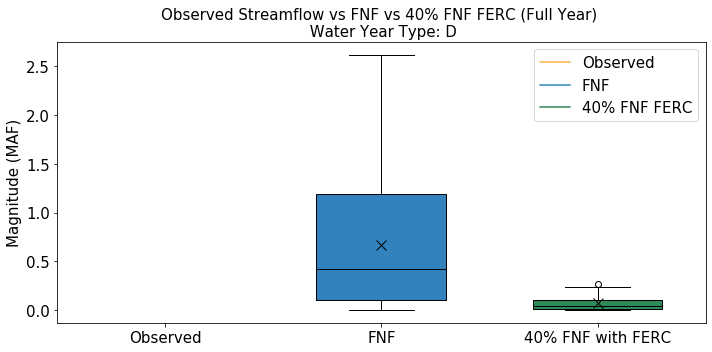

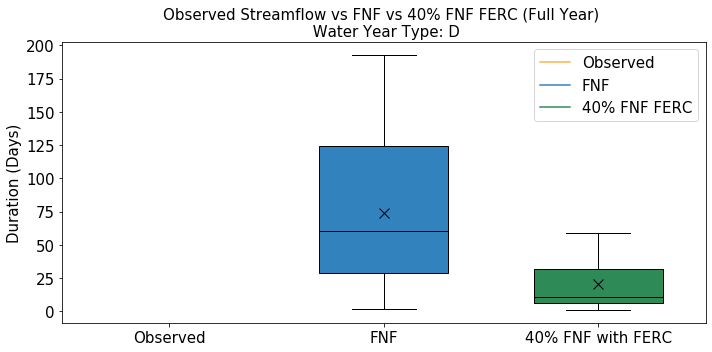

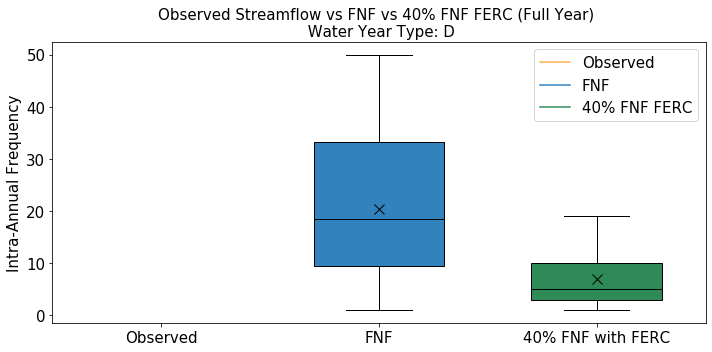

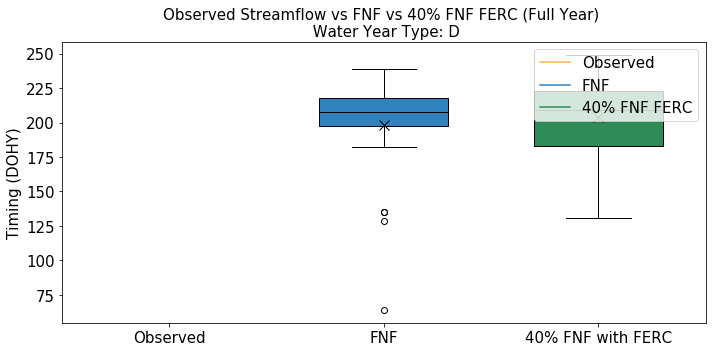

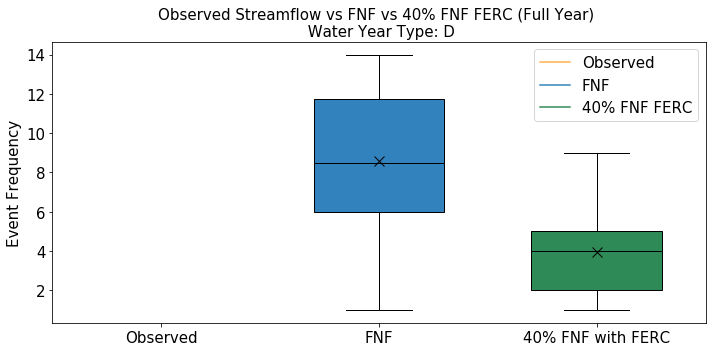

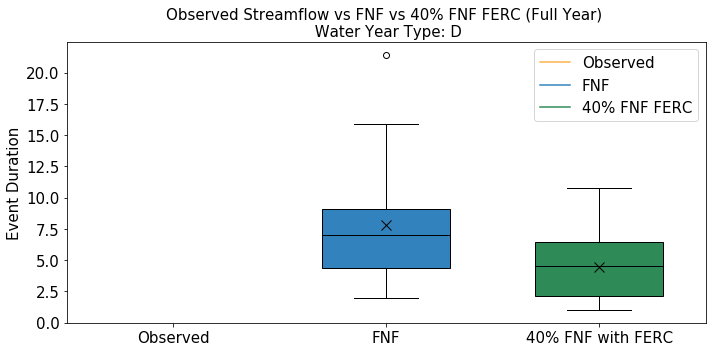

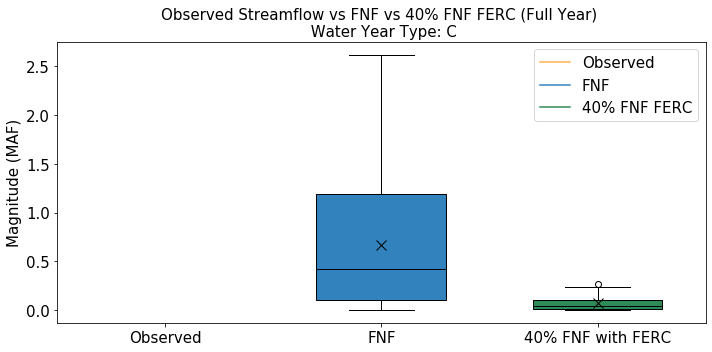

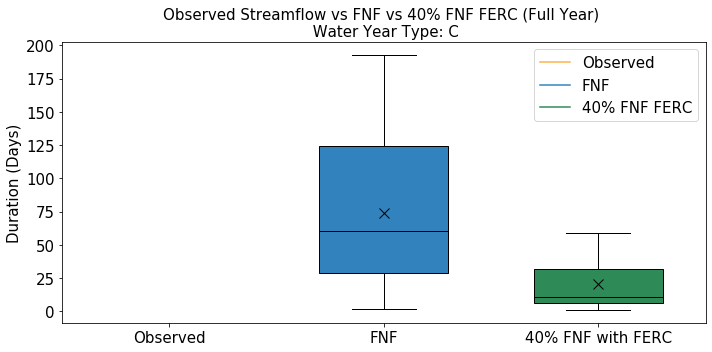

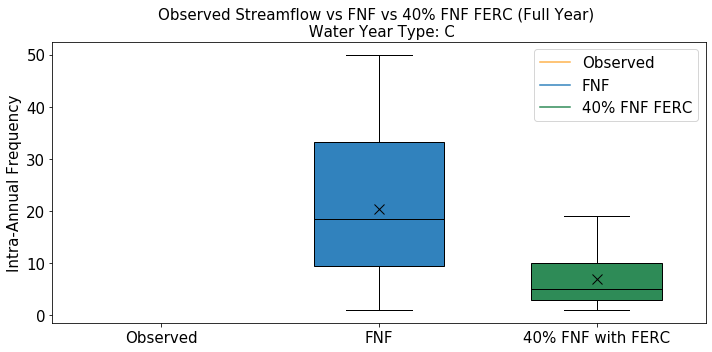

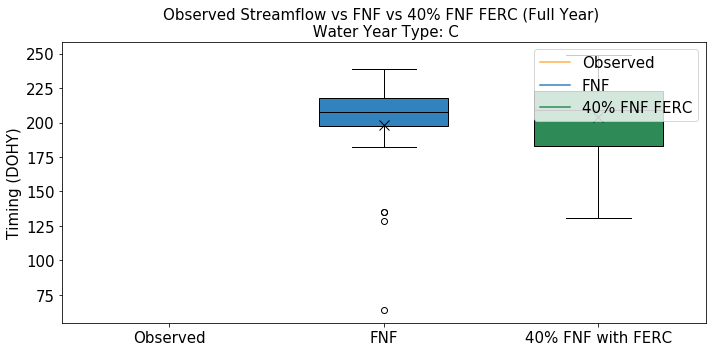

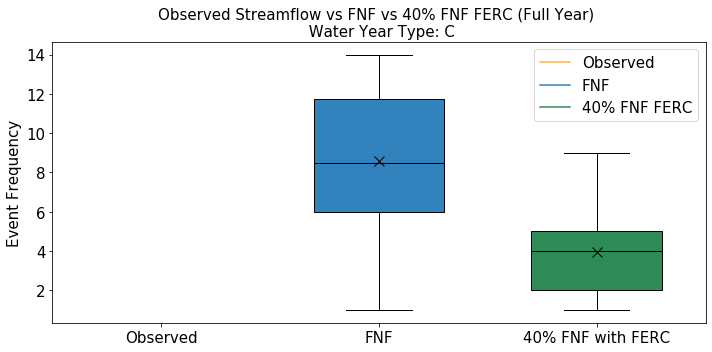

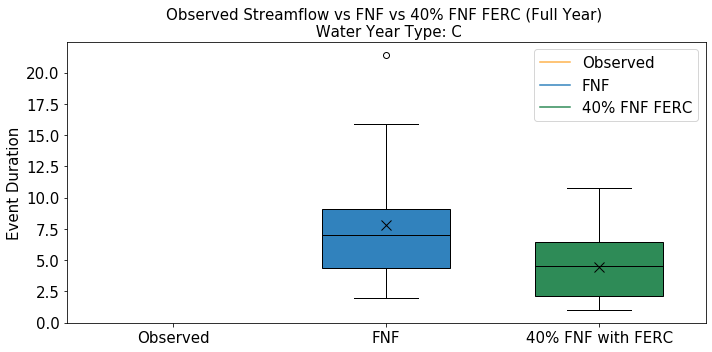

In [35]:
# Boxplots of flow characteristics for observed vs. fnf vs. ferc by WYT

ticks = ['Observed','FNF', "40% FNF with FERC"]
cols = ['mag_maf', 'dur_days', 'intra_ann_fre', 'tim_dohy', 'event_fre', 'event_dur']
yaxes = ['Magnitude (MAF)', 'Duration (Days)', 'Intra-Annual Frequency', 'Timing (DOHY)', 'Event Frequency', 'Event Duration']

for WY_type in WY_types:
    
    for i, col in enumerate(cols):
        
        fig, ax = plt.subplots(figsize=(10,5))
        plot_data = data_obs[(data_obs['WY_type'] == WY_type) & (data_obs[col] != 0)][col]
        ax.boxplot(plot_data, positions=[-1], widths=0.6, patch_artist=True, 
                boxprops=dict(facecolor='#feb24c'), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

        plot_data = data_obs[(data_obs['WY_type'] == WY_type) & (data_obs[col] != 0)][col]
        ax.boxplot(data_fnf[data_fnf[col] != 0][col], positions=[0], widths=0.6, patch_artist=True, #[col+'_4mo']
                boxprops=dict(facecolor='#3182bd'), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
    
        plot_data = data_obs[(data_obs['WY_type'] == WY_type) & (data_obs[col] != 0)][col]
        ax.boxplot(data_fnf_ferc[data_fnf_ferc[col] != 0][col], positions=[1], widths=0.6, patch_artist=True, #[col+'_4mo']
                boxprops=dict(facecolor='seagreen'), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

        # draw temporary red and blue lines and use them to create a legend
        ax.plot([], c='#feb24c', label='Observed')
        ax.plot([], c='#3182bd', label='FNF')
        ax.plot([], c='seagreen', label='40% FNF FERC')
        ax.legend(loc=1, prop={"size":15})

        # customize plot
        plt.xticks([-1,0, 1], ticks, fontsize=15)
        #ax.set_xticks([-1,0], ticks)
        ax.tick_params(axis='y', labelsize=15)
        ax.set_ylabel(yaxes[i], fontsize=15)
        #plt.xlim(-2, len(ticks)*3)
        #plt.ylim(0, 1)
        plt.title(f'Observed Streamflow vs FNF vs 40% FNF FERC (Full Year) \n Water Year Type: {WY_type}', fontsize=15)
        plt.tight_layout()
    
        file_name = f'../results/figures/box_plots/tuol_compare_flows_{col}_{WY_type}.png'
        plt.savefig(file_name, bbox_inches="tight")
        plt.show()

In [36]:
# Intra-ann fre - CHECK
def count_days_per_wy(x):
    return sum(1 for flow in x if flow > 0)

# Intra-annual frequency
def calc_intra_ann_fre(df):
    n = 1
    df['max'] = df['HMF_cfs'].iloc[argrelextrema(df['HMF_cfs'].values, np.greater_equal, order=n, mode='clip')[0]]
    PeaksAbvThreshold = df['max'].resample('AS-OCT').apply(count_days_per_wy)
    #timeseries_annual_obs['intra_ann_fre_days'][site_id] = PeaksAbvThreshold_AllYears
    #AvgPeaksAbvThreshold = PeaksAbvThreshold_AllYears[PeaksAbvThreshold_AllYears != 0].dropna().mean()
    #AnnualAvgPeaksAbvThresholdList.append(AvgPeaksAbvThreshold)
    return PeaksAbvThreshold # returns list

calc_intra_ann_fre(df_test)

NameError: name 'df_test' is not defined

In [ ]:
thresholds_flowDict

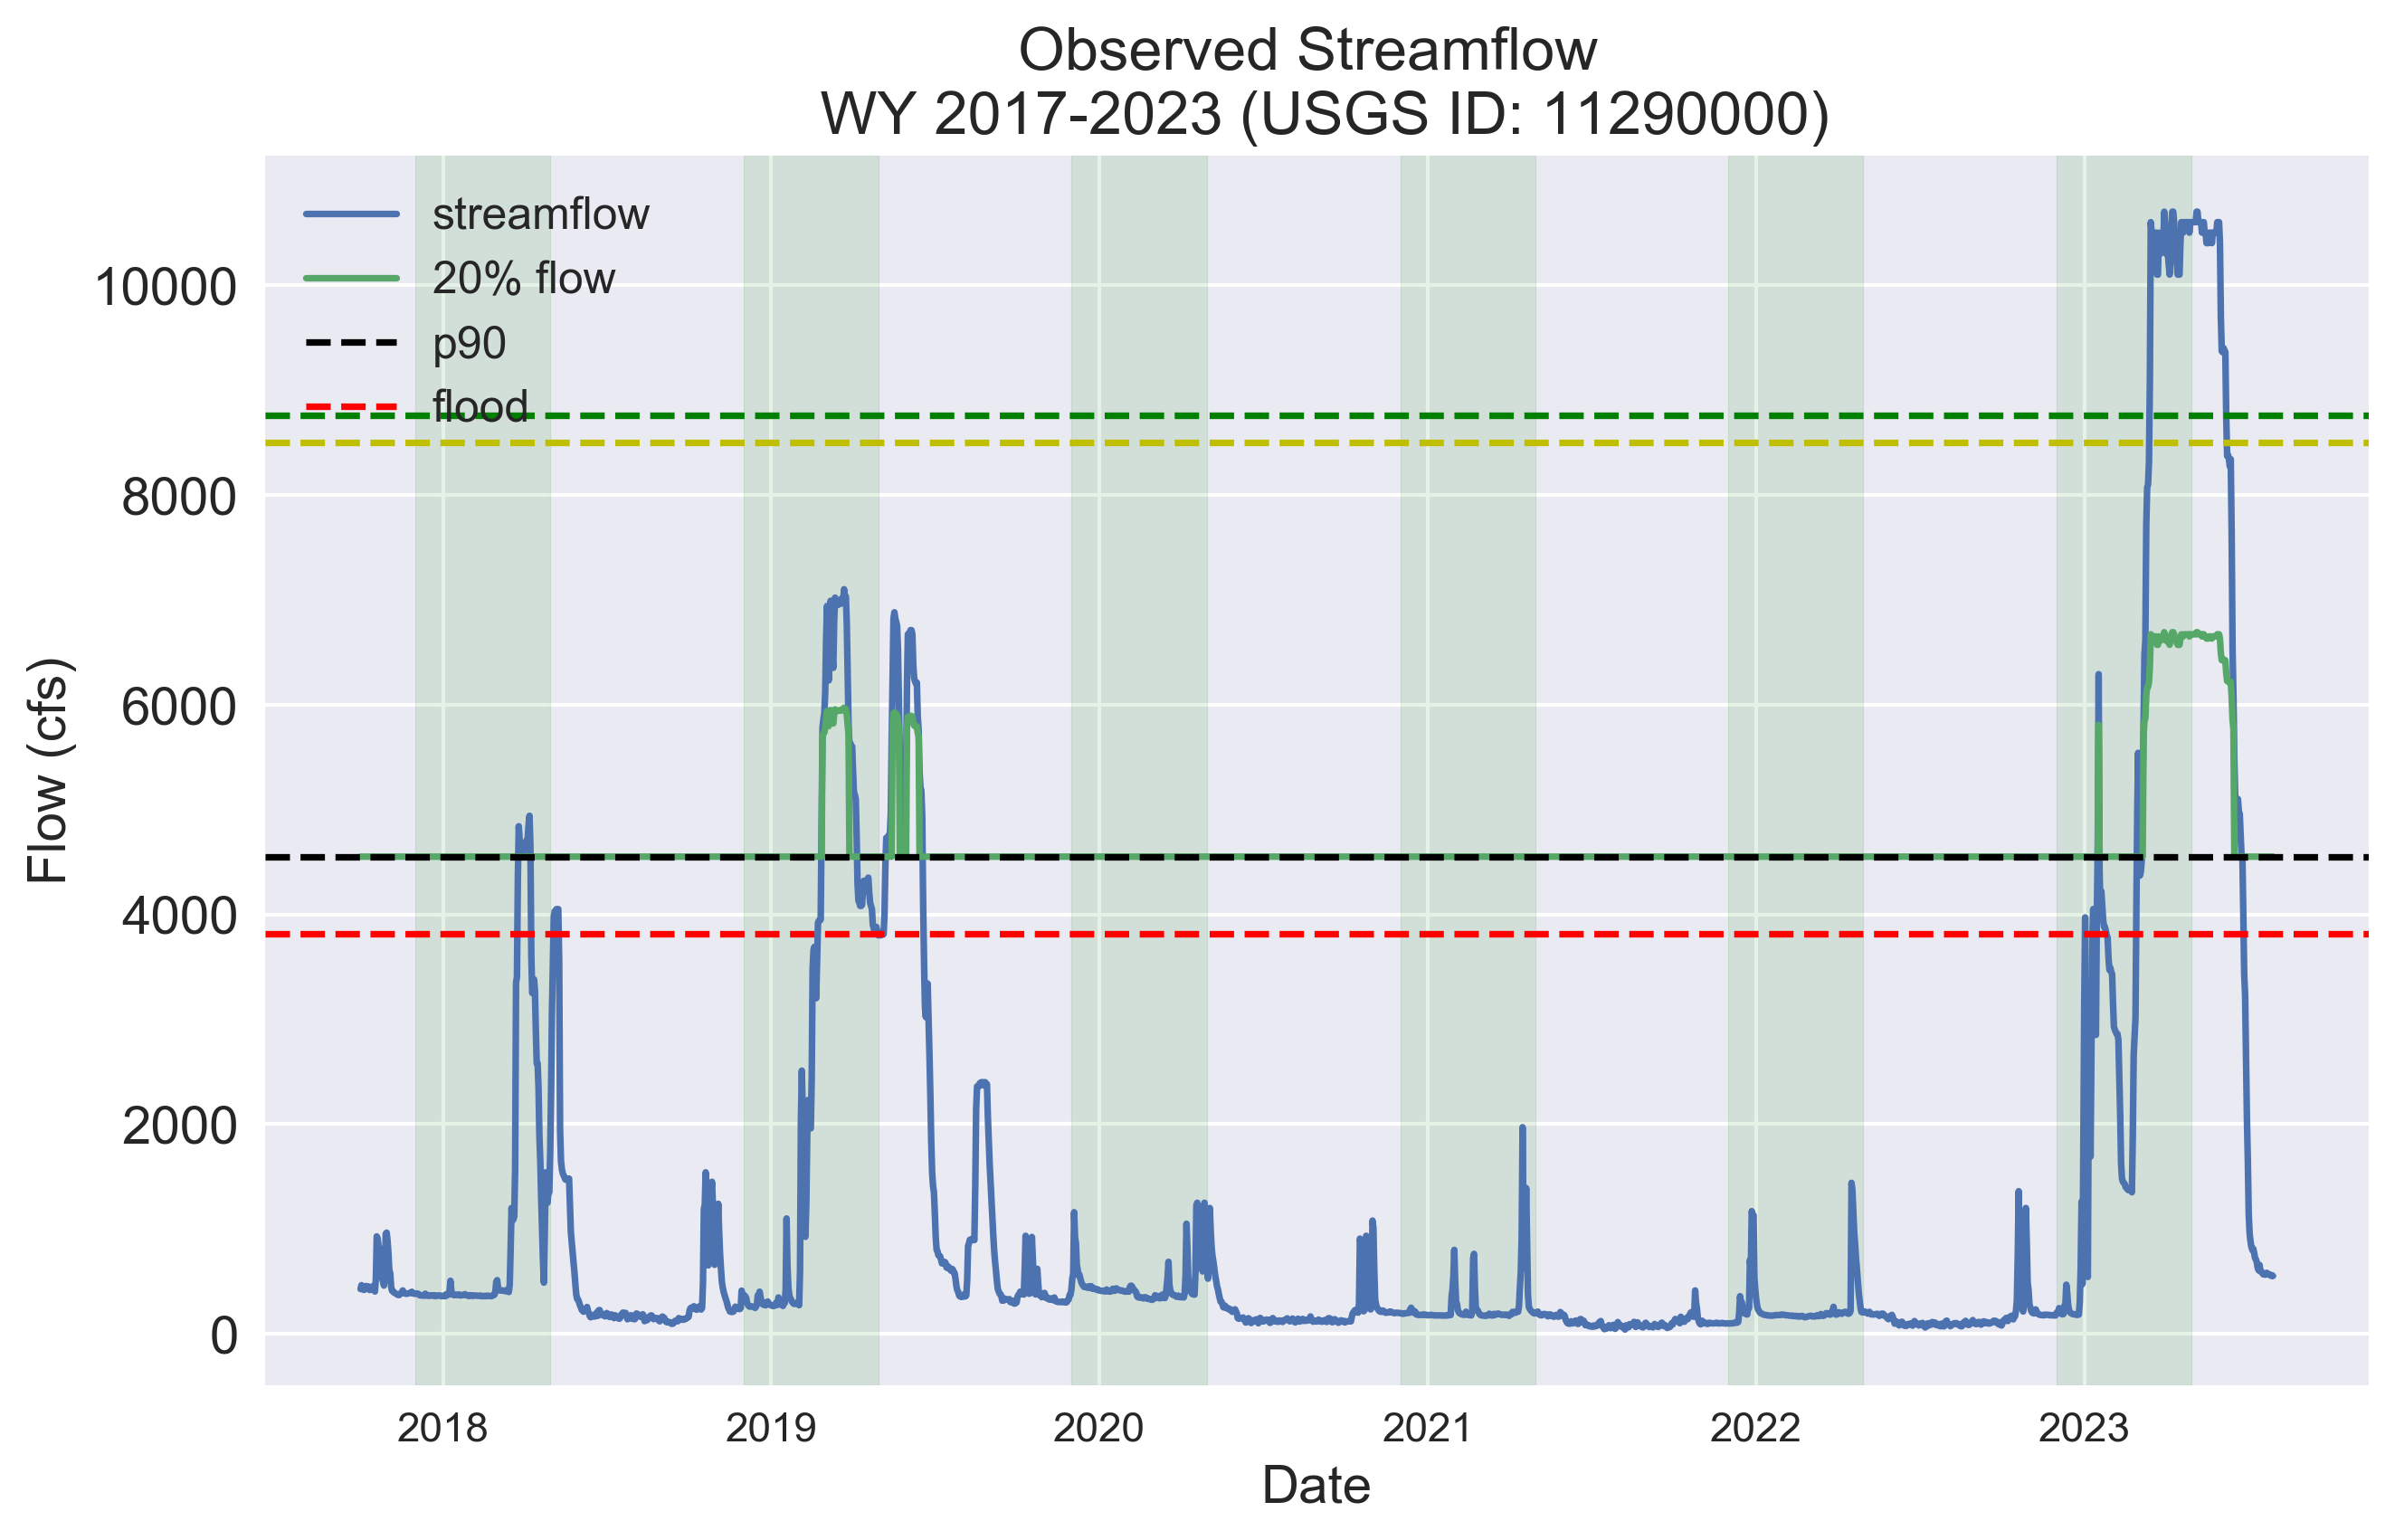

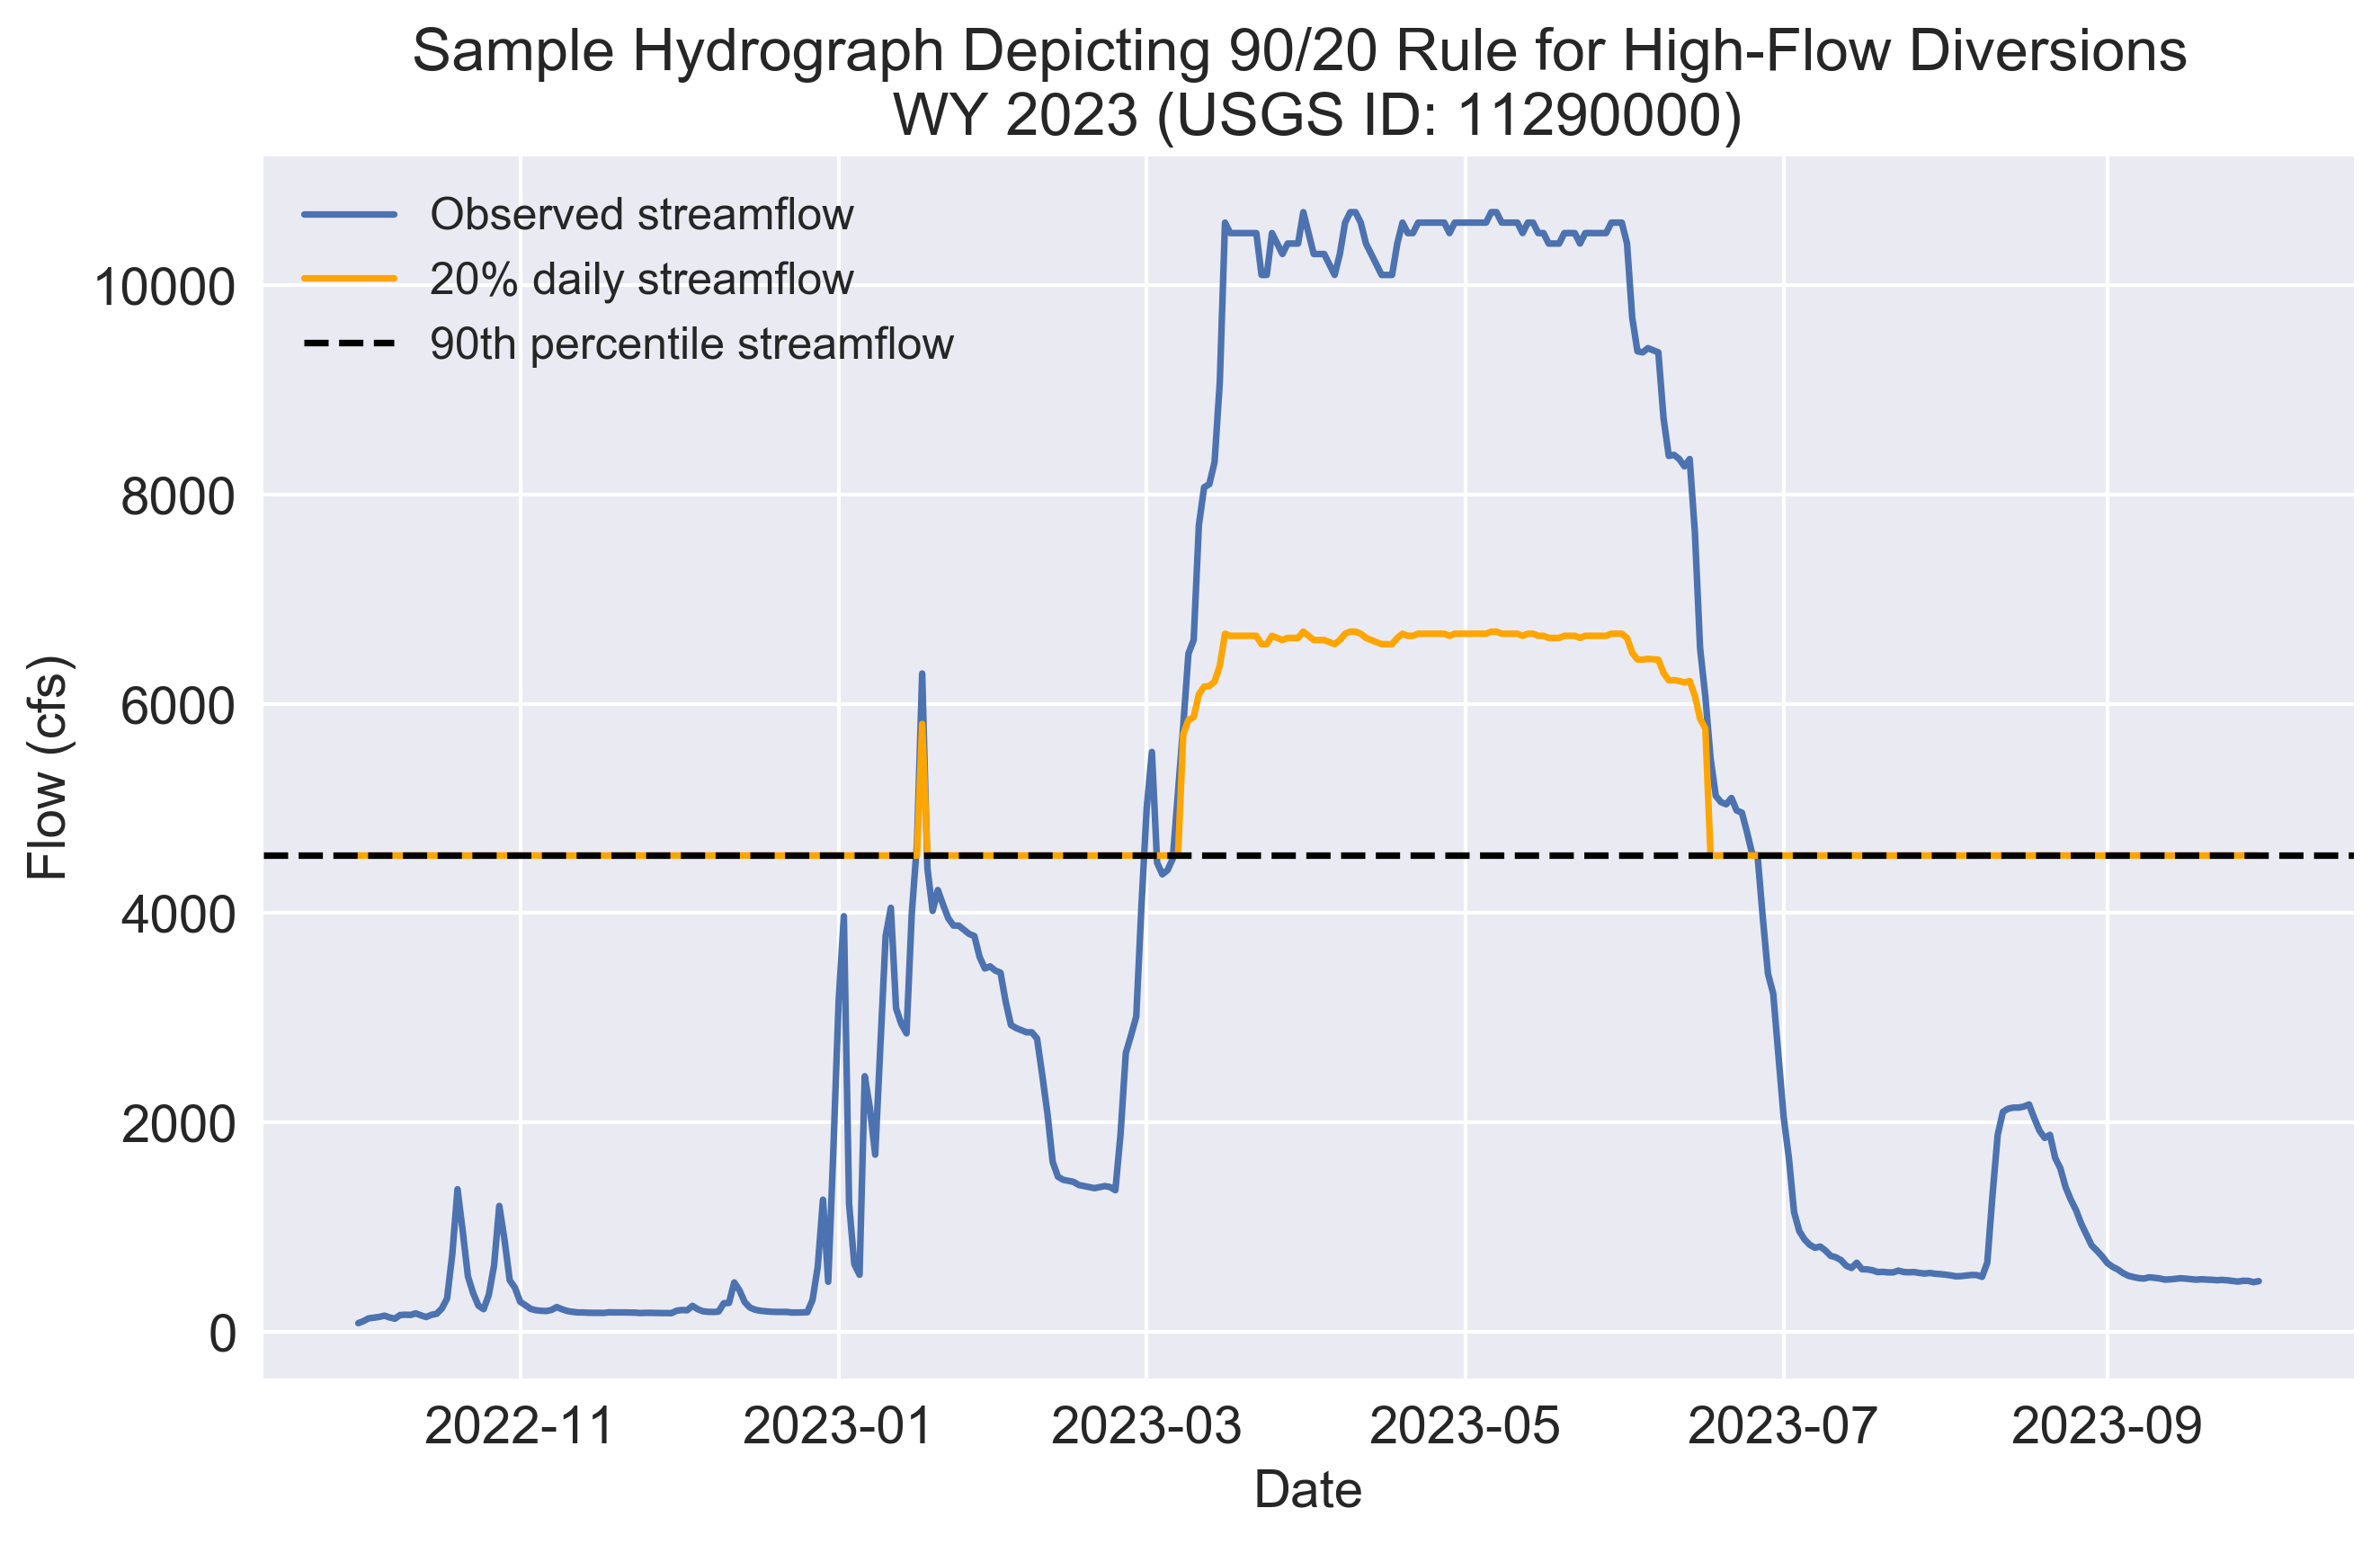

In [37]:
# Timeseries plot
plt.style.use('seaborn')

from datetime import datetime

# import streamflow data for selected data range
start_date = '2017-10-01'
end_date = '2023-07-30'
selected_threshold = 'p90'
for site_id in sites:
    if site_id == 11447650:
        #daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
        #daily1 = nwis.get_record(sites=str(site_id), service='dv', start=start_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
        daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='72137').drop(columns=['72137_Mean_cd', 'site_no']).rename(columns={'72137_Mean': 'flow_cfs'})
        #daily = pd.concat([daily1, daily2])
    else:
        daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})

# convert dates to datetime for axvspan plot function
daily['datetime'] = pd.to_datetime(daily.index)
daily['month'] = daily['datetime'].dt.strftime('%m')
daily['year'] = daily['datetime'].dt.strftime('%Y')

# assign column with 20% of daily streamflow in instances when it is less than flow above p90 exceeds
daily['pct20'] = [flow*0.2 for flow in daily['flow_cfs']]
threshold = float(thresholds_flowDict['obs'][selected_threshold][site_id])
daily['flow_above_threshold_cfs'] = [(flow - threshold) if flow > threshold else 0 for flow in daily['flow_cfs']]
#daily['pct20_plus_threshold'] = [flow*0.2 for flow in daily['flow_cfs']]+thresholds_obs.loc[site_id, 'p90']
daily['p90_pct20_diff'] = daily['flow_above_threshold_cfs'] - daily['pct20']
daily.loc[daily['p90_pct20_diff'] > 0, 'pct20_rev'] = daily['pct20']
daily['pct20_rev'] = daily['pct20_rev'].fillna(0)

# plot streamflow timeseries with thresholds
fig, ax = plt.subplots(dpi=300, figsize=(10,6))
ax.plot(daily['flow_cfs'])
ax.plot(daily['pct20_rev']+thresholds_flowDict['obs'].loc[site_id, 'p90'])
ax.axhline(y = thresholds_flowDict['obs'].loc[site_id, 'p90'], color='black', linestyle='--')
ax.axhline(y = thresholds_flowDict['obs'].loc[site_id, '2yr_event'], color='red', linestyle='--')
# ax.axhline(y = thresholds_obs.loc[site_id, '3yr_event'], color='g')
ax.axhline(y = thresholds_flowDict['obs'].loc[site_id, '5yr_event'], color='green', linestyle='--')
# ax.axhline(y = thresholds_obs.loc[site_id, '10yr_event'], color='m')
ax.axhline(y = thresholds_flowDict['obs'].loc[site_id, 'flood_DWR'], color='y', linestyle='--')
#plt.legend(['streamflow', '20% flow', 'p90'], loc='upper left', prop={'size': 12})
plt.legend(['streamflow', '20% flow', 'p90', 'flood'], loc='upper left', prop={'size': 12})
#plt.legend(['flow', '20pct', 'p90', '2-yr event', '3-yr event', '5-yr event', '10-yr event', 'flood'], loc='upper right', prop={'size': 12})
#plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90'], loc=1, prop={'size': 7})

# shade region from Dec 1 - Apr 30
for year in np.arange(2017, 2023):
    ax.axvspan((datetime(year,12,1)), (datetime(year+1,4,30)),
                label="Labeled",color="green", alpha=0.1, ymin=0, ymax=10000)

ax.set_xlabel('Date', fontsize=14)
ax.tick_params(axis='x', labelsize=11)
ax.set_ylabel('Flow (cfs)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.title('Observed Streamflow \n WY 2017-2023 (USGS ID: %s)' % site_id, fontsize=16)
#plt.savefig('figures/daily_flow/30yr/plot'+str(site_id)+'.png')
#plt.savefig(file_name, bbox_inches="tight")
plt.show()

# import streamflow data for selected data range
start_date = '2022-10-01'
end_date = '2023-09-30'
for site_id in sites:
    if site_id == 11447650:
        #daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
        #daily1 = nwis.get_record(sites=str(site_id), service='dv', start=start_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
        daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='72137').drop(columns=['72137_Mean_cd', 'site_no']).rename(columns={'72137_Mean': 'flow_cfs'})
        #daily = pd.concat([daily1, daily2])
    else:
        daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})

# convert dates to datetime for axvspan plot function
daily['datetime'] = pd.to_datetime(daily.index)
daily['month'] = daily['datetime'].dt.strftime('%m')
daily['year'] = daily['datetime'].dt.strftime('%Y')

# assign column with 20% of daily streamflow in instances when it is less than flow above p90 exceeds
daily['pct20'] = [flow*0.2 for flow in daily['flow_cfs']]
daily['flow_above_threshold_cfs'] = [(flow - threshold) if flow > threshold else 0 for flow in daily['flow_cfs']]
daily['p90_pct20_diff'] = daily['flow_above_threshold_cfs'] - daily['pct20']
daily.loc[daily['p90_pct20_diff'] > 0, 'pct20_rev'] = daily['pct20']
daily['pct20_rev'] = daily['pct20_rev'].fillna(0)

# plot streamflow timeseries with thresholds
fig, ax = plt.subplots(dpi=300, figsize=(10,6))
ax.plot(daily['flow_cfs'], label='Observed streamflow')
ax.plot(daily['pct20_rev']+thresholds_flowDict['obs'].loc[site_id, 'p90'], color='orange', label='20% daily streamflow')
ax.axhline(y = thresholds_flowDict['obs'].loc[site_id, 'p90'], color='black', linestyle='--', label='90th percentile streamflow')
#plt.axhline(y = thresholds_obs.loc[site_id, '2yr_event'], color='r', linestyle='--')
#plt.axhline(y = thresholds_obs.loc[site_id, '3yr_event'], color='g')
#plt.axhline(y = thresholds_obs.loc[site_id, '5yr_event'], color='green', linestyle='--')
#plt.axhline(y = thresholds_obs.loc[site_id, '10yr_event'], color='m')
#plt.axhline(y = thresholds_obs.loc[site_id, 'flood_DWR'], color='y', linestyle='--')
#ax.fill_between(thresholds_obs.loc[site_id, 'p90'], daily['flow_cfs'])

# shade region from Dec 1 - Apr 30
#y0,y1 = ax.get_ylim()
#ax.axvspan((datetime(2022,12,1)), (datetime(2023,4,30)), label="Labeled",color="green", alpha=0.3, ymin=0, ymax=10000)

plt.legend(loc='upper left', prop={'size': 12})
#plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90'], loc=1, prop={'size': 7})
ax.set_xlabel('Date', fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel('Flow (cfs)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.title('Sample Hydrograph Depicting 90/20 Rule for High-Flow Diversions \n WY 2023 (USGS ID: %s)' % site_id, fontsize=16)
file_name = 'results/figures/timeseries/streamflow/'+selected_sites+'/'+selected_record+'_'+selected_sites+'_'+flow_type+'_'+str(site_id)+'.png'
#plt.savefig('figures/daily_flow/30yr/plot'+str(site_id)+'.png')
#plt.savefig('results/figures/timeseries/streamflow/Tuol/'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
plt.show()

In [38]:
# Timeseries plot
#end_date = '2023-03-30'
#daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})

plt.figure(figsize=(10,6))
plt.plot(fnf_tuol['TLG_FNF_CFS'])
plt.axhline(y = thresholds_fnf.loc[site_id, 'p90'], color='black')
plt.axhline(y = thresholds_fnf.loc[site_id, '2yr_event'], color='r')
plt.axhline(y = thresholds_fnf.loc[site_id, '3yr_event'], color='g')
plt.axhline(y = thresholds_fnf.loc[site_id, '5yr_event'], color='b')
plt.axhline(y = thresholds_fnf.loc[site_id, '10yr_event'], color='m')
plt.axhline(y = thresholds_fnf.loc[site_id, 'flood_DWR'], color='y')
plt.legend(['flow', 'p90', '2-yr event', '3-yr event', '5-yr event', '10-yr event', 'flood'], loc='upper right', prop={'size': 12})
#plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90'], loc=1, prop={'size': 7})
plt.xlabel('Date', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Flow (cfs)', fontsize=12)
plt.yticks(fontsize=12)
plt.title('TUOL. R. BL LGR: Full Natural Flow', fontsize=14)
#plt.savefig('figures/daily_flow/30yr/plot'+str(site_id)+'.png')
plt.savefig('results/figures/timeseries/streamflow/Tuol/'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
plt.show()

NameError: name 'fnf_tuol' is not defined

<Figure size 720x432 with 0 Axes>

## Observed vs. full natural flow

In [39]:
# Timeseries plots of flow characteristics
timeseries_annual_fnf = pd.DataFrame.from_dict(timeseries_annual_fnf)
#plt.style.use('seaborn')

# AUTOMATE THIS
#years_11447650 = list(range(1948,2014))
#years_11447650 = enumerate(timeseries_annual['mag_maf'][11447650])
#years_11303500 = list(range(1929,2014))
years_list = list(range(1993, 2022))
#years_list_11271360 = list(range(2015, 2022))

selected_sites = 'Tuol_obs_vs_fnf'

# Magnitude  
#fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,5))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
ax1.plot(years_list, timeseries_annual_obs['mag_maf'][11289650], label='Observed')
ax1.plot(years_list, timeseries_annual_fnf['mag_maf'][11289650], label='FNF')
ax1.axhline(y = results_obs.loc[11289650, 'mag_maf'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax1.axhline(y = results_fnf.loc[11289650, 'mag_maf'], color='orange', linestyle = '-.', label='FNF mean')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Magnitude (Full Year) \n Tuol. R. Bl. La Grange')
ax1.set_xlabel('Year')
ax1.set_ylabel('MAF')

ax2.plot(years_list, timeseries_annual_obs['mag_maf_4mo'][11289650], label='Observed')
ax2.plot(years_list, timeseries_annual_fnf['mag_maf_4mo'][11289650], label='FNF')
ax2.axhline(y = results_obs.loc[11289650, 'mag_maf_4mo'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax2.axhline(y = results_fnf.loc[11289650, 'mag_maf_4mo'], color='orange', linestyle = '-.', label='FNF mean')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Magnitude (Dec - Mar) \n Tuol. R. Bl. La Grange')
ax2.set_xlabel('Year')
ax2.set_ylabel('MAF')

# ax2.plot(years_list, timeseries_annual_obs['mag_maf_6mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax2.plot(years_list, timeseries_annual_fnf['mag_maf_6mo'][11289650], label='TUOL. R. BL LAGRANGE')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.set_title('Magnitude (Nov - Apr)')
# ax2.set_xlabel('Year')
# ax2.set_ylabel('MAF')

# ax3.plot(years_list, timeseries_annual_obs['mag_maf_3mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax3.plot(years_list, timeseries_annual_fnf['mag_maf_3mo'][11289650], label='TUOL. R. BL LAGRANGE')
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax3.set_title('Magnitude (Dec - Feb)')
# ax3.set_xlabel('Year')
# ax3.set_ylabel('MAF')
plt.tight_layout()
plt.savefig('results/figures/timeseries/flow_char/Tuol/mag_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

# Duration
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
ax1.plot(years_list, timeseries_annual_obs['dur_days'][11289650], label='Observed')
ax1.plot(years_list, timeseries_annual_fnf['dur_days'][11289650], label='FNF')
ax1.axhline(y = results_obs.loc[11289650, 'dur_days'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax1.axhline(y = results_fnf.loc[11289650, 'dur_days'], color='orange', linestyle = '-.', label='FNF mean')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Duration (Full Year) \n Tuol. R. Bl. La Grange')
ax1.set_xlabel('Year')
ax1.set_ylabel('Days per Year')

ax2.plot(years_list, timeseries_annual_obs['dur_days_4mo'][11289650], label='Observed')
ax2.plot(years_list, timeseries_annual_fnf['dur_days_4mo'][11289650], label='FNF')
ax2.axhline(y = results_obs.loc[11289650, 'dur_days_4mo'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax2.axhline(y = results_fnf.loc[11289650, 'dur_days_4mo'], color='orange', linestyle = '-.', label='FNF mean')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Duration (Dec - Mar) \n Tuol. R. Bl. La Grange')
ax2.set_xlabel('Year')
ax2.set_ylabel('Days per Year')

# ax2.plot(years_list, timeseries_annual_obs['dur_days_6mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.set_title('Duration (Nov - Apr)')
# ax2.set_xlabel('Year')
# ax2.set_ylabel('Days per Year')

# ax3.plot(years_list, timeseries_annual_obs['dur_days_3mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax3.set_title('Duration (Dec - Feb)')
# ax3.set_xlabel('Year')
# ax3.set_ylabel('Days per Year')
plt.tight_layout()
plt.savefig('results/figures/timeseries/flow_char/Tuol/dur_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

# Intra-annual frequency
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
ax1.plot(years_list, timeseries_annual_obs['intra_ann_fre_days'][11289650], label='Observed')
ax1.plot(years_list, timeseries_annual_fnf['intra_ann_fre_days'][11289650], label='FNF')
ax1.axhline(y = results_obs.loc[11289650, 'intra_ann_fre'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax1.axhline(y = results_fnf.loc[11289650, 'intra_ann_fre'], color='orange', linestyle = '-.', label='FNF mean')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Intra-Annual Frequency (Full Year) \n Tuol. R. Bl. La Grange')
ax1.set_xlabel('Year')
ax1.set_ylabel('Days per Year')

ax2.plot(years_list, timeseries_annual_obs['intra_ann_fre_days_4mo'][11289650], label='Observed')
ax2.plot(years_list, timeseries_annual_fnf['intra_ann_fre_days_4mo'][11289650], label='FNF')
ax2.axhline(y = results_obs.loc[11289650, 'intra_ann_fre_4mo'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax2.axhline(y = results_fnf.loc[11289650, 'intra_ann_fre_4mo'], color='orange', linestyle = '-.', label='FNF mean')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Intra-Annual Frequency (Nov - Apr) \n Tuol. R. Bl. La Grange')
ax2.set_xlabel('Year')
ax2.set_ylabel('Days per Year')

# ax2.plot(years_list, timeseries_annual_obs['intra_ann_fre_days_6mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.set_title('Intra-Annual Frequency (Nov - Apr)')
# ax2.set_xlabel('Year')
# ax2.set_ylabel('Days per Year')

# ax3.plot(years_list, timeseries_annual_obs['intra_ann_fre_days_3mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax3.set_title('Intra-Annual Frequency (Dec - Feb)')
# ax3.set_xlabel('Year')
# ax3.set_ylabel('Days per Year')
plt.tight_layout()
plt.savefig('results/figures/timeseries/flow_char/Tuol/intra_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

# Inter-annual frequency
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
ax1.scatter(years_list, timeseries_annual_obs['inter_ann_fre'][11289650], label='Observed')
ax1.scatter(years_list, timeseries_annual_fnf['inter_ann_fre'][11289650], label='FNF')
ax1.axhline(y = results_obs.loc[11289650, 'inter_ann_fre'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax1.axhline(y = results_fnf.loc[11289650, 'inter_ann_fre'], color='orange', linestyle = '-.', label='FNF mean')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Inter-Annual Frequency (Full Year) \n Tuol. R. Bl. La Grange')
ax1.set_xlabel('Year')
ax1.set_ylabel('HMF Year')

ax2.scatter(years_list, timeseries_annual_obs['inter_ann_fre_4mo'][11289650], label='Observed)')
ax2.scatter(years_list, timeseries_annual_fnf['inter_ann_fre_4mo'][11289650], label='FNF')
ax2.axhline(y = results_obs.loc[11289650, 'inter_ann_fre_4mo'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax2.axhline(y = results_fnf.loc[11289650, 'inter_ann_fre_4mo'], color='orange', linestyle = '-.', label='FNF mean')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Inter-Annual Frequency (Nov - Apr) \n Tuol. R. Bl. La Grange')
ax2.set_xlabel('Year')
ax2.set_ylabel('HMF Year')

# ax2.scatter(years_list, timeseries_annual_obs['inter_ann_fre_6mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.set_title('Inter-Annual Frequency (Nov - Apr)')
# ax2.set_xlabel('Year')
# ax2.set_ylabel('HMF Year')

# ax3.scatter(years_list, timeseries_annual_obs['inter_ann_fre_3mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax3.set_title('Inter-Annual Frequency (Dec - Feb)')
# ax3.set_xlabel('Year')
# ax3.set_ylabel('HMF Year')
plt.tight_layout()
plt.savefig('results/figures/timeseries/flow_char/Tuol/inter_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

# Timing (COM)
fig, ax1 = plt.subplots(figsize=(10,1.8))
ax1.plot(years_list, timeseries_annual_obs['tim_hdoy'][11289650], label='Observed')
ax1.plot(years_list, timeseries_annual_fnf['tim_hdoy'][11289650], label='FNF')
ax1.axhline(y = results_obs.loc[11289650, 'tim_hdoy'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax1.axhline(y = results_fnf.loc[11289650, 'tim_hdoy'], color='orange', linestyle = '-.', label='FNF mean')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Timing (Full Year) \n Tuol. R. Bl. La Grange')
ax1.set_xlabel('Year')
ax1.set_ylabel('HDOY')
plt.tight_layout()
plt.savefig('results/figures/timeseries/flow_char/Tuol/tim_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

# Number of events
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
ax1.plot(years_list, timeseries_annual_obs['event_dur_days'][11289650], label='Observed')
ax1.plot(years_list, timeseries_annual_fnf['event_dur_days'][11289650], label='FNF')
ax1.axhline(y = results_obs.loc[11289650, 'event_dur_days'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax1.axhline(y = results_fnf.loc[11289650, 'event_dur_days'], color='orange', linestyle = '-.', label='FNF mean')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Frequency (Full Year) \n Tuol. R. Bl. La Grange')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Events')

ax2.plot(years_list, timeseries_annual_obs['event_dur_days_4mo'][11289650], label='Observed')
ax2.plot(years_list, timeseries_annual_fnf['event_dur_days_4mo'][11289650], label='FNF')
ax2.axhline(y = results_obs.loc[11289650, 'event_dur_days_4mo'], color='#1f77b4', linestyle = '-.', label='Observed mean' )
ax2.axhline(y = results_fnf.loc[11289650, 'event_dur_days_4mo'], color='orange', linestyle = '-.', label='FNF mean')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Frequency (Nov - Apr) \n Tuol. R. Bl. La Grange')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Events')

# ax2.plot(years_list, timeseries_annual_obs['event_dur_days_6mo'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.set_title('Frequency (Nov-Apr)')
# ax2.set_xlabel('Year')
# ax2.set_ylabel('Number of Events')

# ax3.plot(years_list, timeseries_annual_obs['event_dur_days'][11289650], label='TUOL. R. BL LAGRANGE (OBS)')
# ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax3.set_title('Frequency (Dec-Mar)')
# ax3.set_xlabel('Year')
# ax3.set_ylabel('Number of Events')
plt.tight_layout()
plt.savefig('results/figures/timeseries/flow_char/Tuol/event_dur_'+selected_threshold+'_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
plt.show()

NameError: name 'timeseries_annual_fnf' is not defined

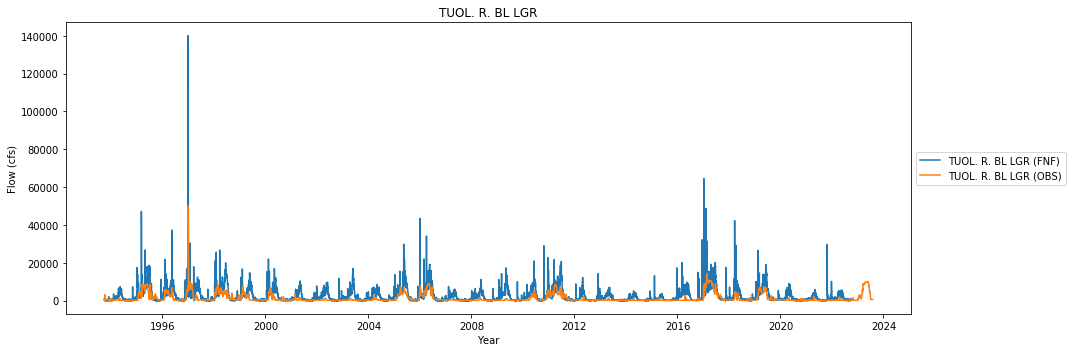

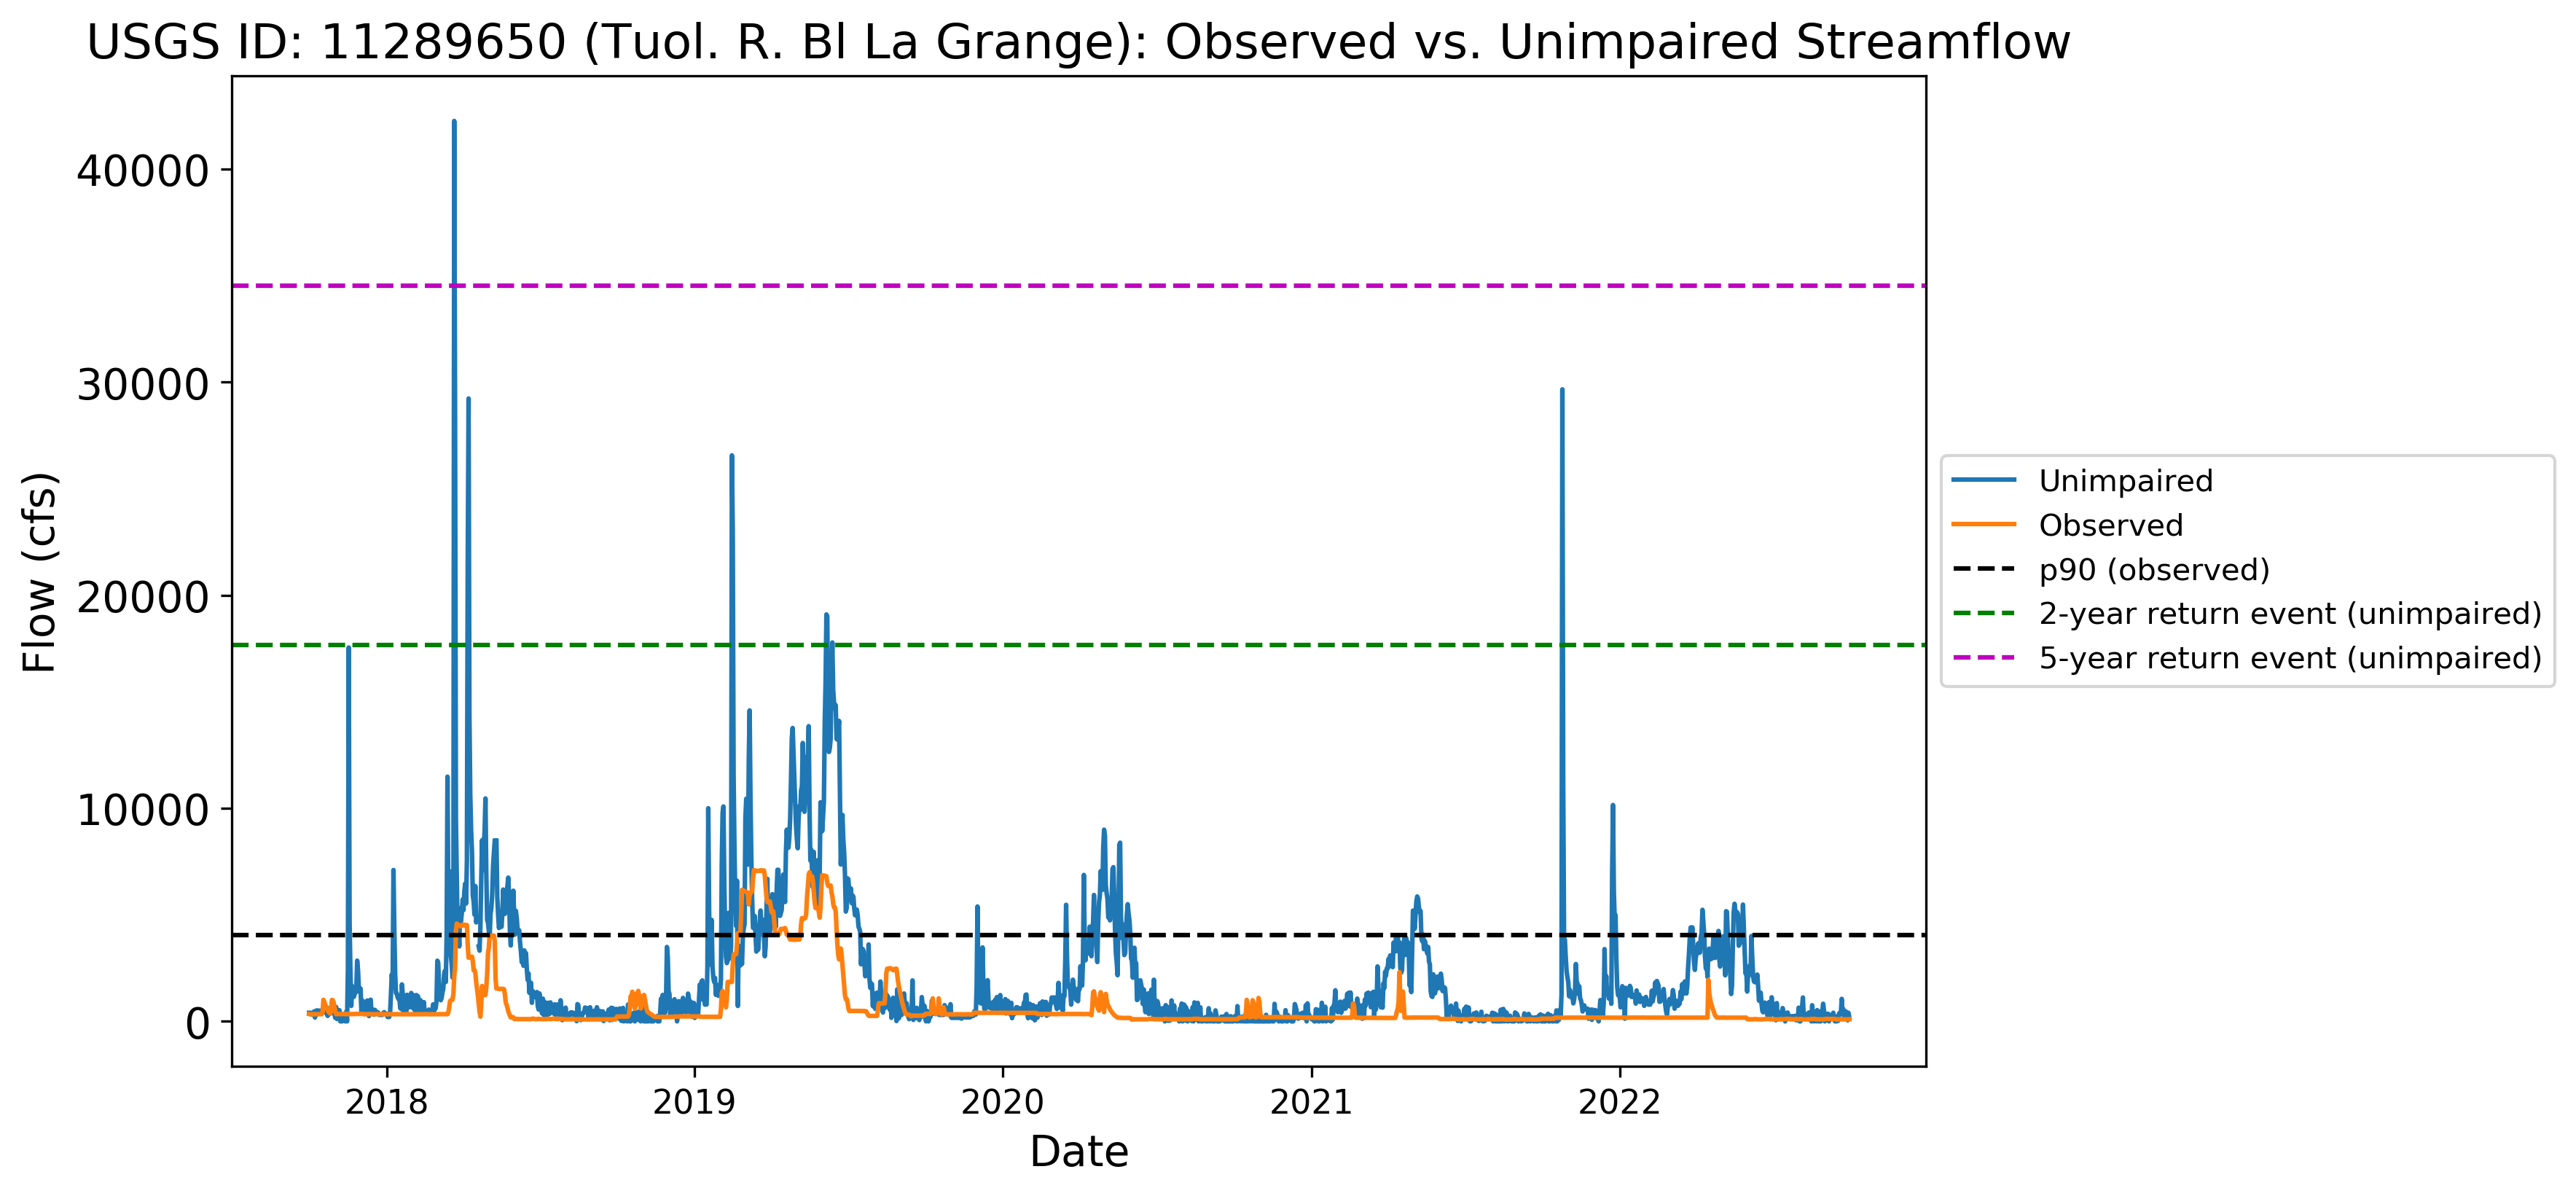

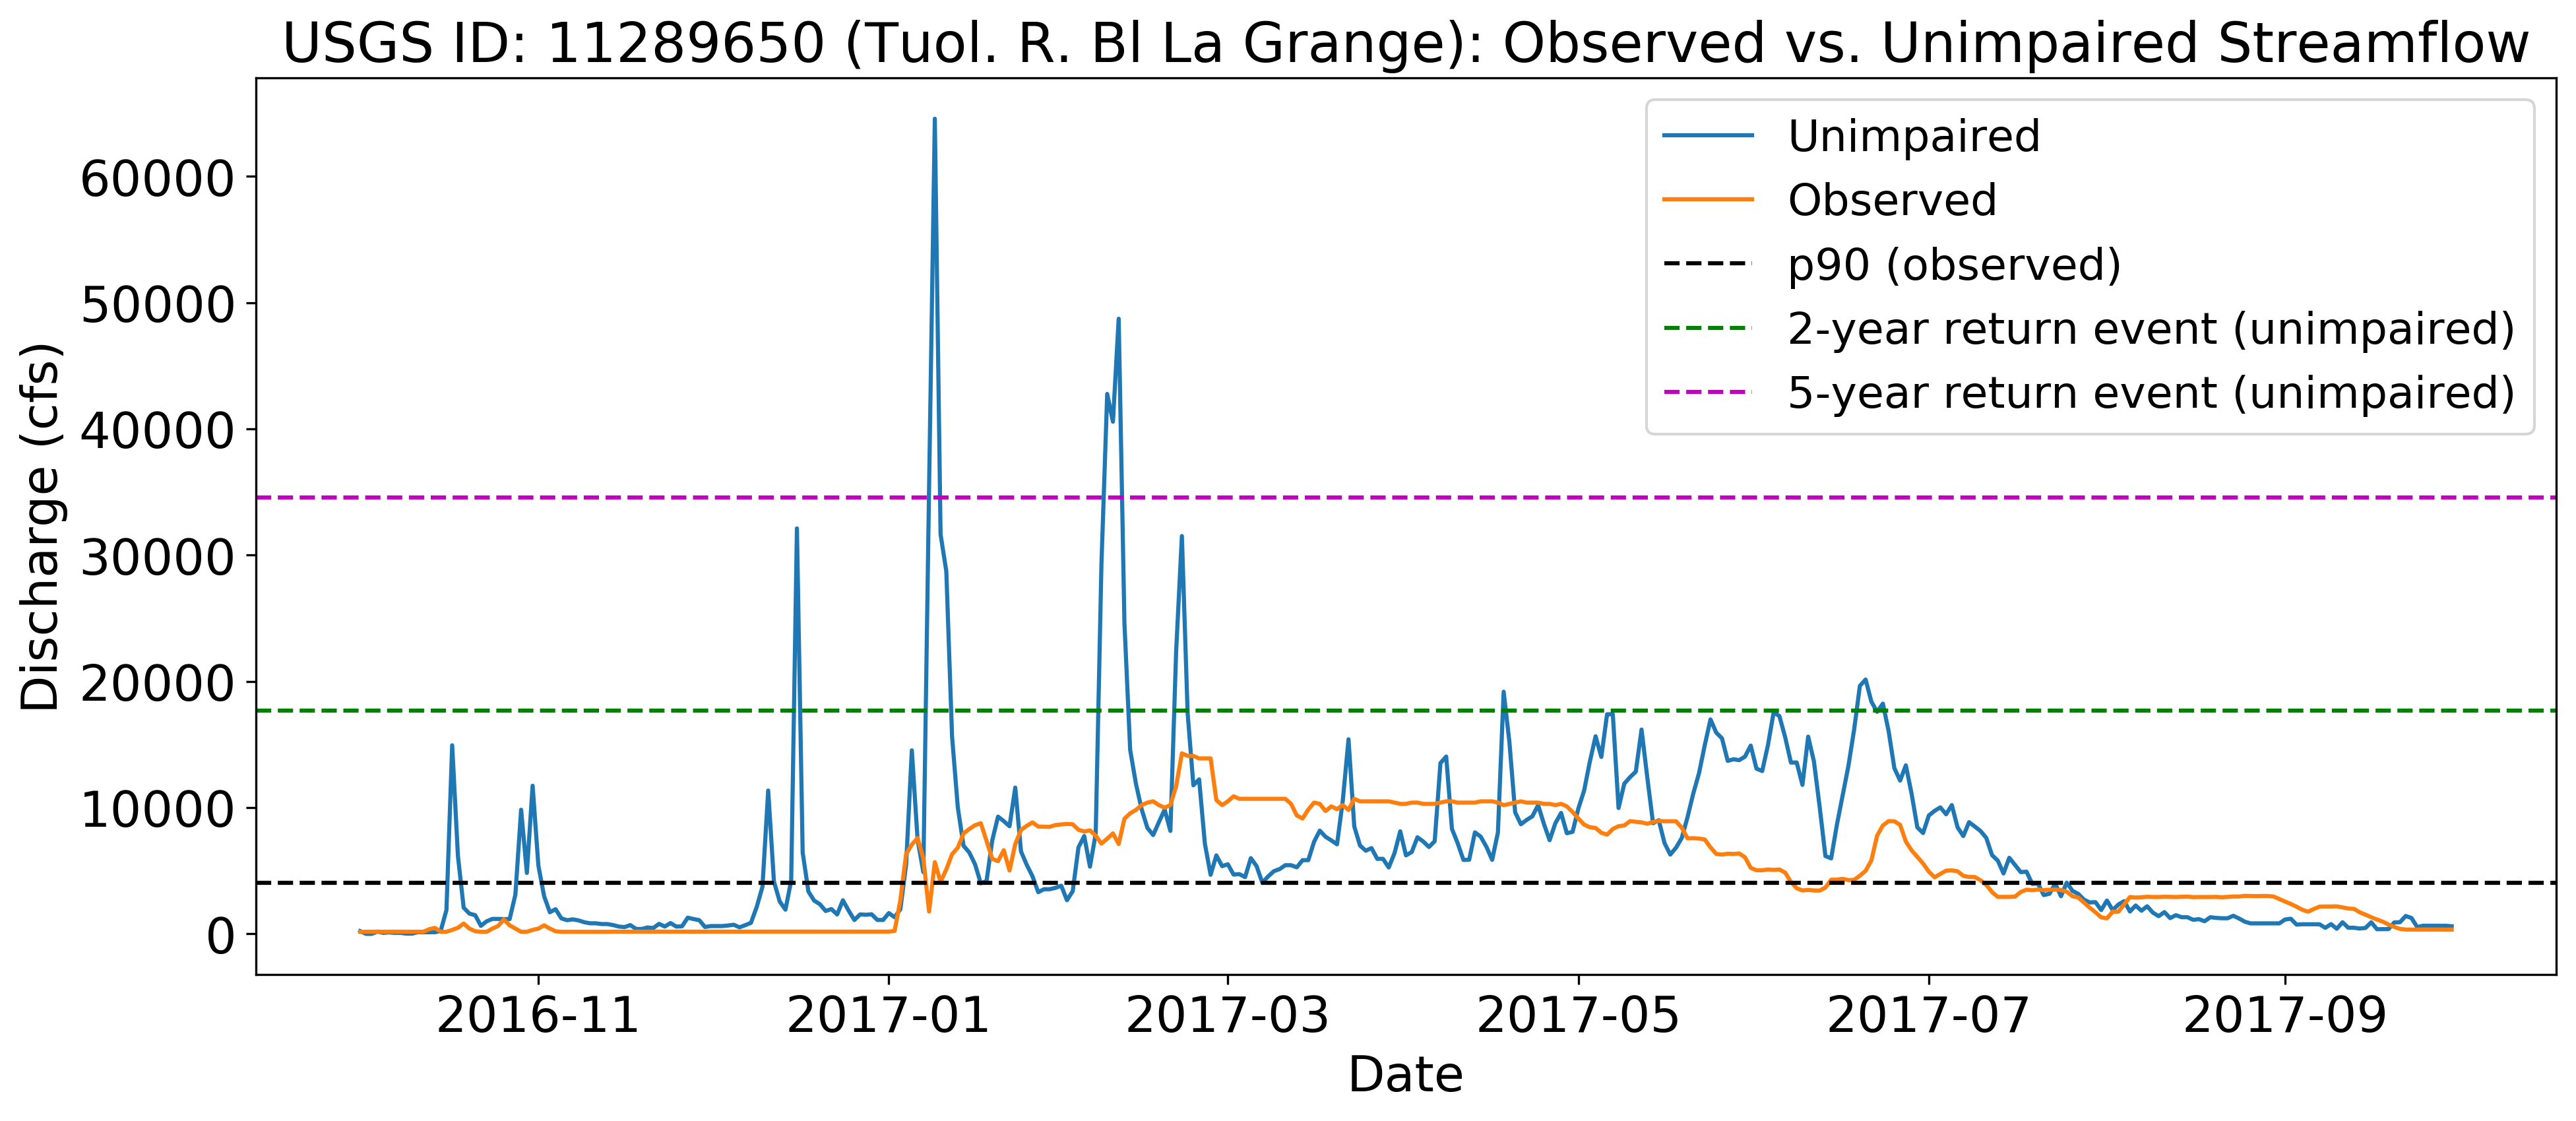

In [32]:
# Timeseries plot
selected_sites = 'Tuol_obs_vs_fnf'

start_date = '1993-10-01'
end_date = '2023-07-30'
daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})

fig, (ax1) = plt.subplots(1,1, figsize=(15,5))
ax1.plot(fnf_tuol['TLG_FNF_CFS'], label='TUOL. R. BL LGR (FNF)')
ax1.plot(daily['flow_cfs'], label='TUOL. R. BL LGR (OBS)')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('TUOL. R. BL LGR')
ax1.set_xlabel('Year')
ax1.set_ylabel('Flow (cfs)')
plt.tight_layout()
plt.savefig('results/figures/timeseries/streamflow/Tuol/'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
plt.show()

#start_date = '2017-10-01'
#end_date = '2023-07-30'
fig, ax = plt.subplots(dpi=300, figsize=(10,6))
ax.plot(fnf_tuol['TLG_FNF_CFS']['2017-10-01':'2022-09-30'], label='Unimpaired')
ax.plot(daily['flow_cfs']['2017-10-01':'2022-09-30'], label='Observed')
ax.axhline(y = thresholds_obs.loc[site_id, 'p90'], color='black', linestyle='--', label='p90 (observed)')
ax.axhline(y = thresholds_fnf.loc[site_id, '2yr_event'], color='g', linestyle='--', label='2-year return event (unimpaired)')
#plt.axhline(y = thresholds_obs.loc[site_id, '3yr_event'], color='g')
ax.axhline(y = thresholds_fnf.loc[site_id, '5yr_event'], color='m', linestyle='--', label='5-year return event (unimpaired)')
#plt.axhline(y = thresholds_obs.loc[site_id, '10yr_event'], color='m')
#plt.axhline(y = thresholds_obs.loc[site_id, 'flood_DWR'], color='y', linestyle='--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# shade region from Dec 1 - Apr 30
#y0,y1 = ax.get_ylim()
#offset = daily['flow_cfs'].max()
#new_max = (offset - y0) / (y1 - y0)
#ax.axvspan((datetime(2022,12,1)), (datetime(2023,4,30)), label="Labeled",color="green", alpha=0.3, ymin=0, ymax=10000)
#plt.legend(['streamflow', '20% flow', 'p90', 'flood capacity'], loc='upper left', prop={'size': 12})
#plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90'], loc=1, prop={'size': 7})
ax.set_xlabel('Date', fontsize=14)
ax.tick_params(axis='x', labelsize=11)
ax.set_ylabel('Flow (cfs)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.title('USGS ID: %s (Tuol. R. Bl La Grange): Observed vs. Unimpaired Streamflow' % site_id, fontsize=16)
#plt.savefig('figures/daily_flow/30yr/plot'+str(site_id)+'.png')
#plt.savefig('results/figures/timeseries/streamflow/Tuol/'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(15,6))
ax.plot(fnf_tuol['TLG_FNF_CFS']['2016-10-01':'2017-09-30'], label='Unimpaired')
ax.plot(daily['flow_cfs']['2016-10-01':'2017-09-30'], label='Observed')
ax.axhline(y = thresholds_obs.loc[site_id, 'p90'], color='black', linestyle='--', label='p90 (observed)')
ax.axhline(y = thresholds_fnf.loc[site_id, '2yr_event'], color='g', linestyle='--', label='2-year return event (unimpaired)')
#plt.axhline(y = thresholds_obs.loc[site_id, '3yr_event'], color='g')
ax.axhline(y = thresholds_fnf.loc[site_id, '5yr_event'], color='m', linestyle='--', label='5-year return event (unimpaired)')
#plt.axhline(y = thresholds_obs.loc[site_id, '10yr_event'], color='m')
#plt.axhline(y = thresholds_obs.loc[site_id, 'flood_DWR'], color='y', linestyle='--')
ax.legend(loc='upper right', fontsize=16) #, bbox_to_anchor=(1, 0.5)
# shade region from Dec 1 - Apr 30
#y0,y1 = ax.get_ylim()
#offset = daily['flow_cfs'].max()
#new_max = (offset - y0) / (y1 - y0)
#ax.axvspan((datetime(2022,12,1)), (datetime(2023,4,30)), label="Labeled",color="green", alpha=0.3, ymin=0, ymax=10000)
#plt.legend(['streamflow', '20% flow', 'p90', 'flood capacity'], loc='upper left', prop={'size': 12})
#plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90'], loc=1, prop={'size': 7})
ax.set_xlabel('Date', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_ylabel('Discharge (cfs)', fontsize=18)
ax.tick_params(axis='y', labelsize=18)
plt.title('USGS ID: %s (Tuol. R. Bl La Grange): Observed vs. Unimpaired Streamflow' % site_id, fontsize=20)
#plt.savefig('figures/daily_flow/30yr/plot'+str(site_id)+'.png')
#plt.savefig('results/figures/timeseries/streamflow/Tuol/'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
plt.show()

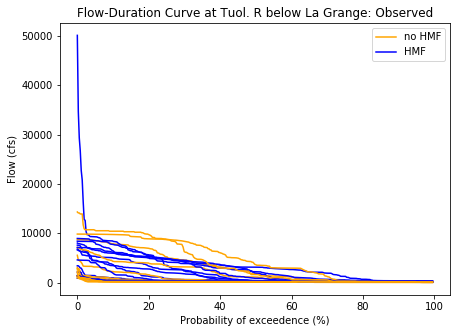

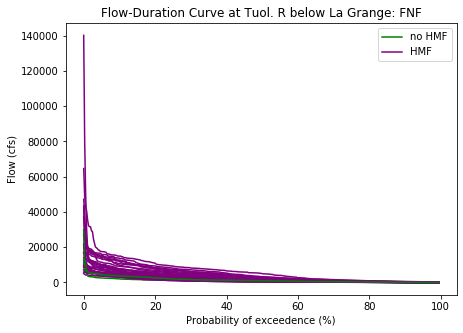

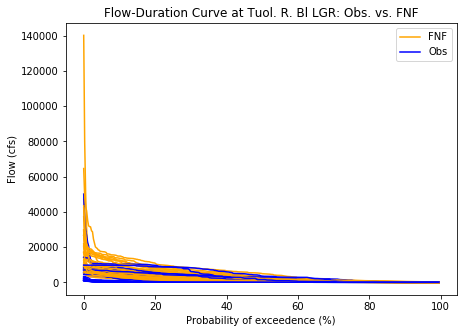

In [33]:
# Flow duration curve
selected_sites = 'Tuol_obs_vs_fnf'

daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
daily['datetime'] = pd.to_datetime(daily.index)
daily['month'] = daily['datetime'].dt.strftime('%m')
daily['year'] = daily['datetime'].dt.strftime('%Y')
daily['WY'] = np.where((daily['month'] == '10') | (daily['month'] == '11') | (daily['month'] == '12'), daily['year'].astype(int) + 1, daily['year'].astype(int))
daily['WY'] = daily['WY'].values.astype(str)
threshold = float(thresholds_obs[selected_threshold][site_id])
FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in daily['flow_cfs']]
daily['flow_above_threshold_cfs'] = FlowAbvThresholdList
HMFyears_obs = daily.loc[daily['flow_above_threshold_cfs'] != 0].WY.unique() # list of years with HMFs

# Observed flows - different color for each year
# plt.figure(figsize=(7,5))
# for year in np.arange(1993, 2022):
#     dailyYr = daily[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['flow_cfs'], ascending=False)
#     pExc = []
#     for i in range(len(dailyYr)):
#         pExc.append(i/(len(dailyYr)+1)*100)
#     dailyYr['pExc'] = pExc
#     #print(dfYr)
#     plt.plot(pExc, dailyYr['flow_cfs'])
# plt.xlabel('Probability of exceedence (%)')
# plt.ylabel('Flow (cfs)')
# plt.title('Flow-Duration Curve at Tuol. R below La Grange: Observed')
# #plt.savefig('11467000_RussianR_FlowDurationCurve.png')
# plt.show()

# Observed flows - HMF year vs non-HMF year
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

selected_sites = 'tuol_obs'
fig, (ax1) = plt.subplots(1,1, figsize=(7,5))
for year in np.arange(1993, 2023):
    if str(year) in HMFyears_obs:
        dailyYr = daily[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['flow_cfs'], ascending=False)
        pExc = [i/(len(dailyYr)+1)*100 for i in range(len(dailyYr))]
        #dailyYr['pExc'] = pExc
        ax1.plot(pExc, dailyYr['flow_cfs'], color='blue', label='HMF')
    else:
        #pass
        dailyYr = daily[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['flow_cfs'], ascending=False)
        pExc = [i/(len(dailyYr)+1)*100 for i in range(len(dailyYr))]
        #dailyYr['pExc'] = pExc
        ax1.plot(pExc, dailyYr['flow_cfs'], color='orange', label='no HMF')
legend_without_duplicate_labels(ax1)
ax1.set_xlabel('Probability of exceedence (%)')
ax1.set_ylabel('Flow (cfs)')
ax1.set_title('Flow-Duration Curve at Tuol. R below La Grange: Observed')
plt.savefig('results/figures/flow_duration/Tuol/'+selected_record+'_'+selected_sites+'_'+'.png', bbox_inches="tight")
#plt.savefig('11467000_RussianR_FlowDurationCurve.png')
plt.show()

# FNF
#daily = pd.DataFrame()
#daily['flow_cfs'] = fnf_tuol['TLG_FNF_CFS']
fnf_tuol['datetime'] = pd.to_datetime(fnf_tuol.index)
fnf_tuol['month'] = fnf_tuol['datetime'].dt.strftime('%m')
fnf_tuol['year'] = fnf_tuol['datetime'].dt.strftime('%Y')
fnf_tuol['WY'] = np.where((fnf_tuol['month'] == '10') | (fnf_tuol['month'] == '11') | (fnf_tuol['month'] == '12'), fnf_tuol['year'].astype(int) + 1, fnf_tuol['year'].astype(int))
fnf_tuol['WY'] = fnf_tuol['WY'].values.astype(str)
threshold = float(thresholds_fnf[selected_threshold][site_id])
FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in fnf_tuol['TLG_FNF_CFS']]
fnf_tuol['flow_above_threshold_cfs'] = FlowAbvThresholdList
HMFyears_fnf = fnf_tuol.loc[fnf_tuol['flow_above_threshold_cfs'] != 0].WY.unique() # list of years with HMFs

# FNF - different color for each year
# plt.figure(figsize=(7,5))
# for year in np.arange(1993, 2022):
#     fnf_tuolYr = fnf_tuol[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['TLG_FNF_CFS'], ascending=False)
#     pExc_fnf = []
#     for i in range(len(fnf_tuolYr)):
#         pExc_fnf.append(i/(len(fnf_tuolYr)+1)*100)
#     fnf_tuolYr['pExc'] = pExc_fnf
#     plt.plot(pExc_fnf, fnf_tuolYr['TLG_FNF_CFS'])
# plt.xlabel('Probability of exceedence (%)')
# plt.ylabel('Flow (cfs)')
# plt.title('Flow-Duration Curve at Tuol. R below La Grange: FNF')
# #plt.savefig('11467000_RussianR_FlowDurationCurve.png')
# plt.show()

# FNF - HMF year vs non-HMF year
selected_sites = 'tuol_fnf'
fig, (ax1) = plt.subplots(1,1, figsize=(7,5))
for year in np.arange(1993, 2023):
    if str(year) in HMFyears_fnf:
        #print(year)
        fnf_tuolYr = fnf_tuol[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['TLG_FNF_CFS'], ascending=False)
        pExc_fnf = [i/(len(fnf_tuolYr)+1)*100 for i in range(len(fnf_tuolYr))]
        #fnf_tuolYr['pExc'] = pExc_fnf
        ax1.plot(pExc_fnf, fnf_tuolYr['TLG_FNF_CFS'], color = 'purple', label='HMF')
    else:
        #print(year)
        fnf_tuolYr = fnf_tuol[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['TLG_FNF_CFS'], ascending=False)
        pExc_fnf = [i/(len(fnf_tuolYr)+1)*100 for i in range(len(fnf_tuolYr))]
        #fnf_tuolYr['pExc'] = pExc_fnf
        ax1.plot(pExc_fnf, fnf_tuolYr['TLG_FNF_CFS'], color='green', label='no HMF')
legend_without_duplicate_labels(ax1)
ax1.set_xlabel('Probability of exceedence (%)')
ax1.set_ylabel('Flow (cfs)')
ax1.set_title('Flow-Duration Curve at Tuol. R below La Grange: FNF')
plt.savefig('results/figures/flow_duration/Tuol/'+selected_record+'_'+selected_sites+'_'+'.png', bbox_inches="tight")
plt.show()

# Observed vs. FNF
selected_sites = 'tuol_obs_vs_fnf'
fig, (ax1) = plt.subplots(1,1, figsize=(7,5))
for year in np.arange(1993, 2023):
    
    fnf_tuolYr = fnf_tuol[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['TLG_FNF_CFS'], ascending=False)
    pExc_fnf = [i/(len(fnf_tuolYr)+1)*100 for i in range(len(fnf_tuolYr))]
    fnf_tuolYr['pExc'] = pExc_fnf
    #print(dfYr)
    ax1.plot(pExc_fnf, fnf_tuolYr['TLG_FNF_CFS'], color = 'orange')
    
    dailyYr = daily[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['flow_cfs'], ascending=False)
    pExc_obs = [i/(len(dailyYr)+1)*100 for i in range(len(dailyYr))]
    dailyYr['pExc'] = pExc_obs
    #print(dfYr)
    ax1.plot(pExc_obs, dailyYr['flow_cfs'], color = 'b')    
ax1.legend(['FNF', 'Obs'], loc='upper right') #bbox_to_anchor=(1, 0.5)
ax1.set_xlabel('Probability of exceedence (%)')
ax1.set_ylabel('Flow (cfs)')
ax1.set_title('Flow-Duration Curve at Tuol. R. Bl LGR: Obs. vs. FNF')
plt.savefig('results/figures/flow_duration/Tuol/'+selected_record+'_'+selected_sites+'_'+'.png', bbox_inches="tight")
plt.show()

11289650
2023-07-30 00:00:00+00:00


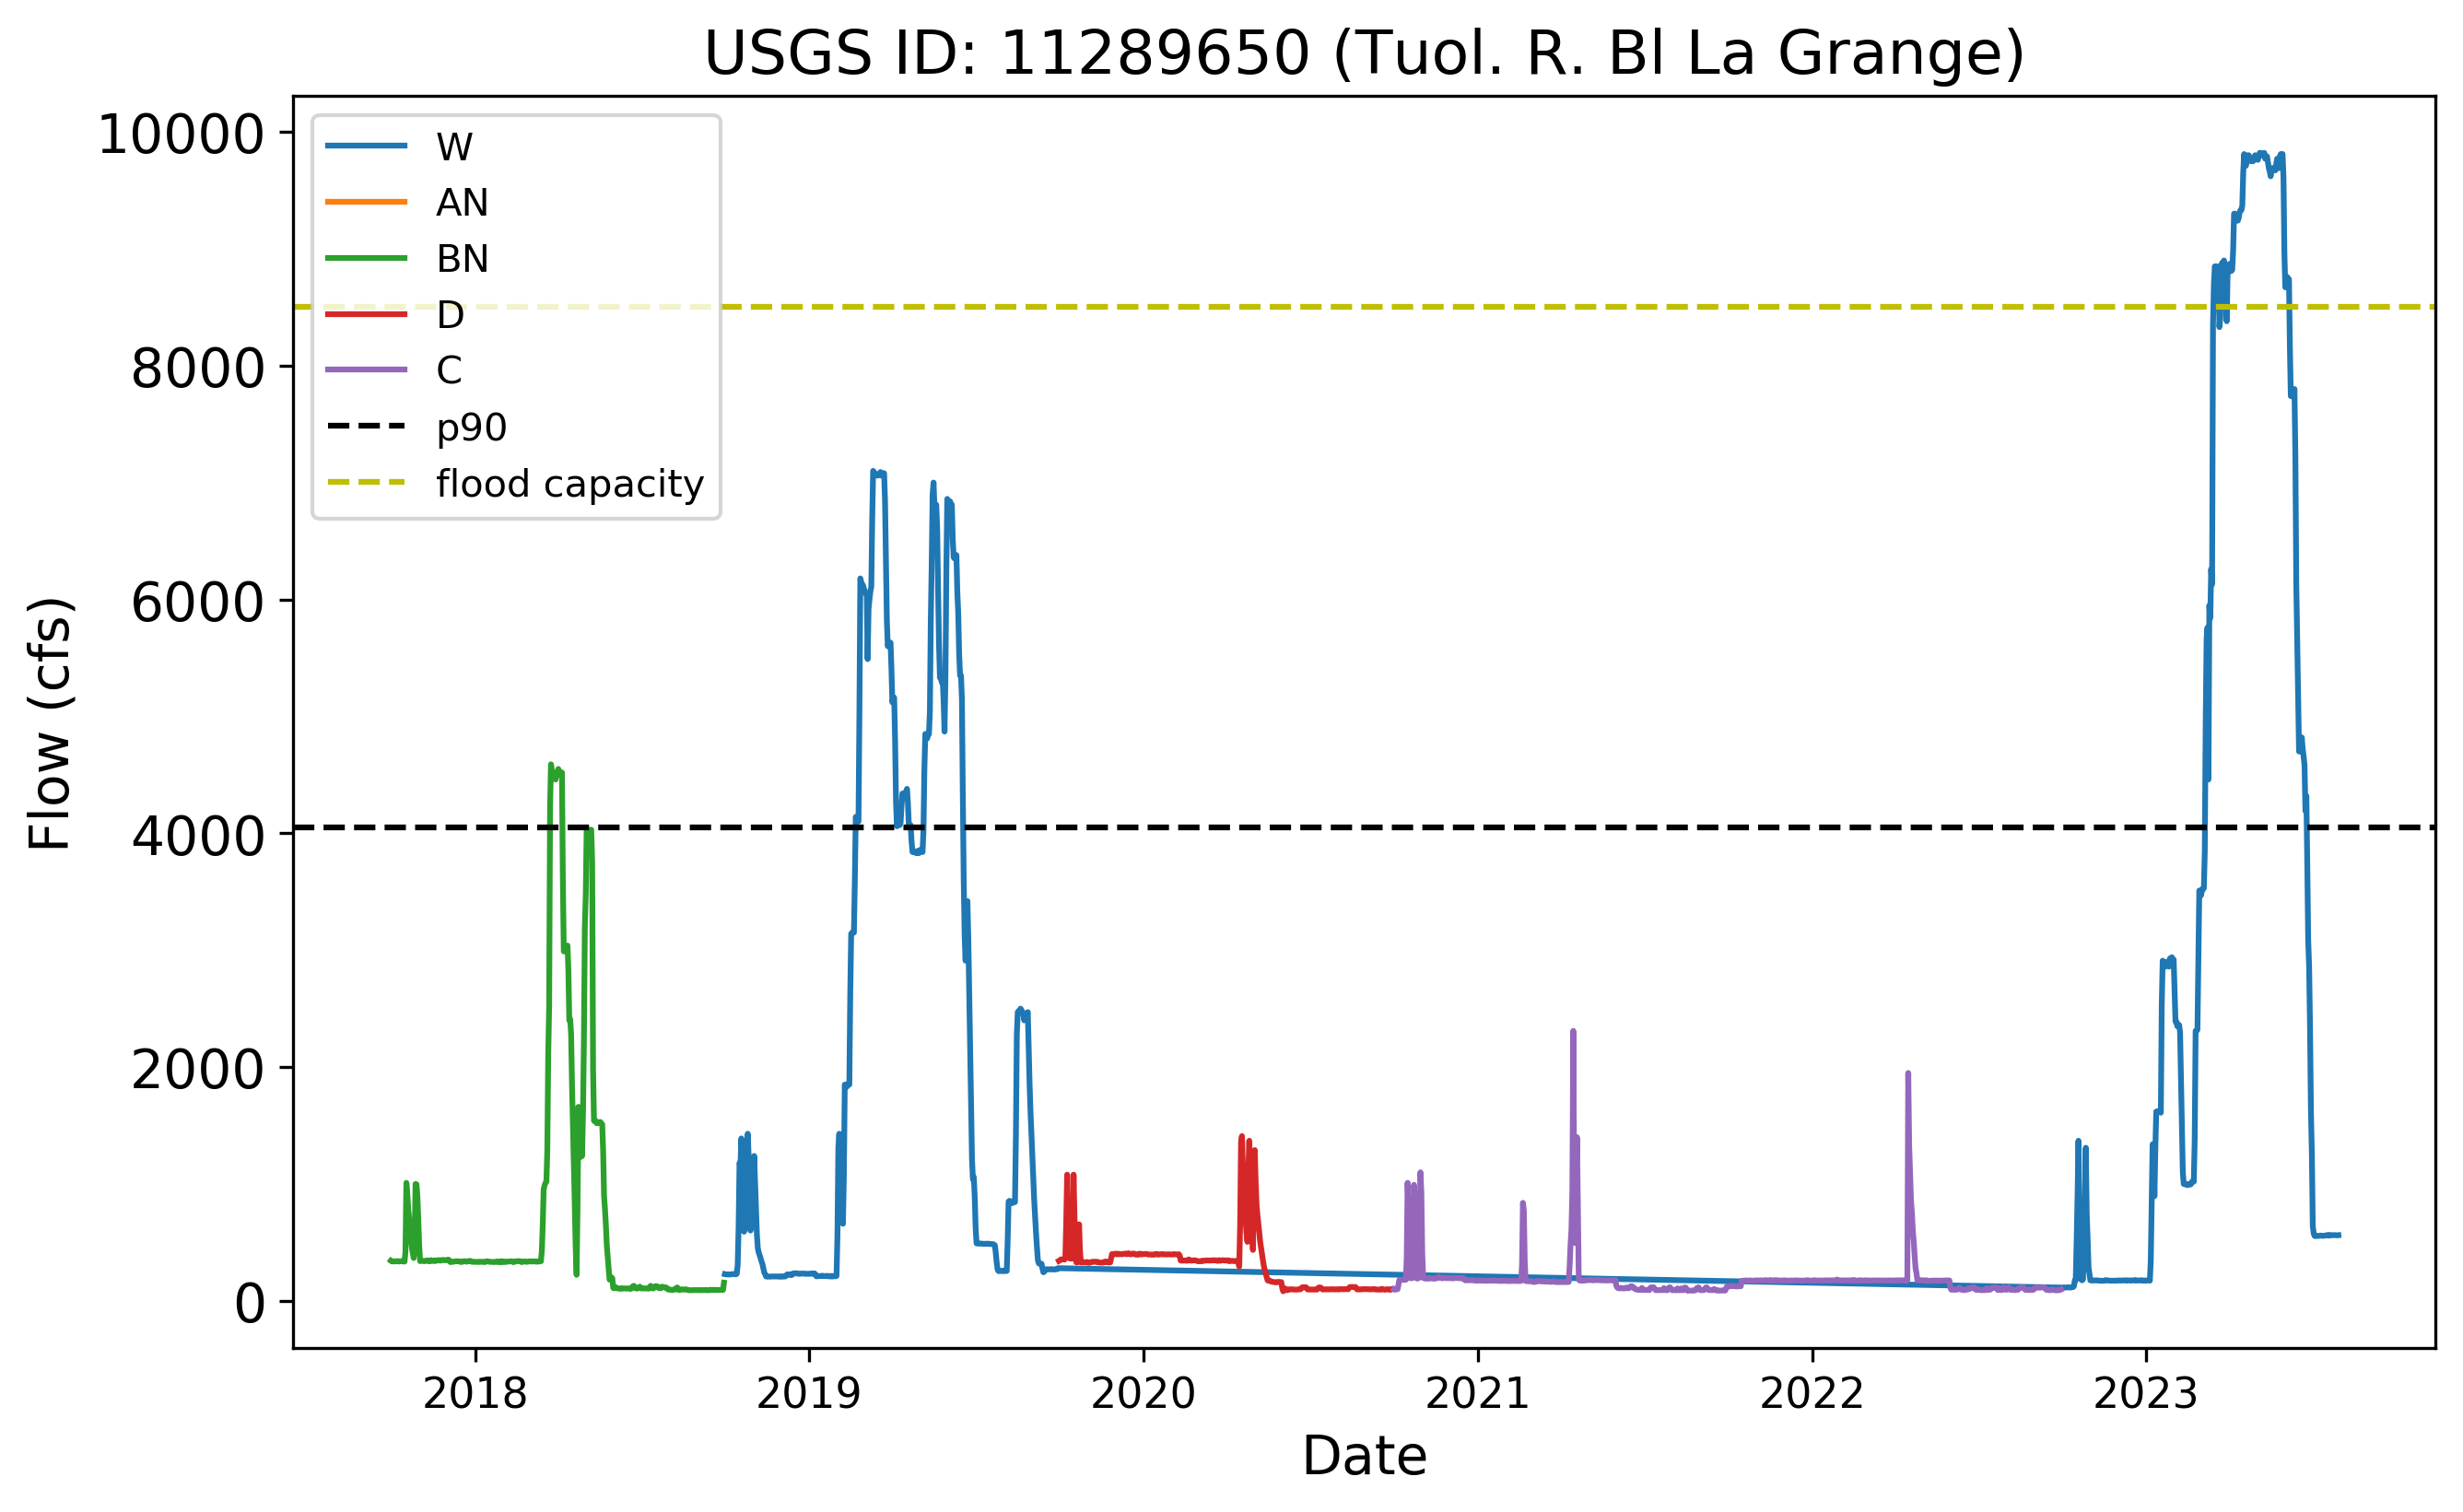

In [71]:
# Timeseries plot colored by WY type

selected_threshold = 'p90'
#selected_threshold = '2yr_event'
#selected_threshold = '3yr_event'
#selected_threshold = '5yr_event'
#selected_threshold = '10yr_event'

#selected_sites = 'SRB_SJB'
selected_sites = 'Tuol'

#selected_record = 'full_rec'
selected_record = '30yr_rec'
#selected_record = 'post-imp'

start_year = '2017'
start_date = start_year+'-10-01'
#end_date = '2022-09-30'
end_date = '2023-07-30'

for site_id in sites:
    if site_id == 11447650:
        #daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
        daily1 = nwis.get_record(sites=str(site_id), service='dv', start=start_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
        daily2 = nwis.get_record(sites=str(site_id), service='dv', start='2015-10-01', end=end_date, parameterCd='72137').drop(columns=['72137_Mean_cd', 'site_no']).rename(columns={'72137_Mean': 'flow_cfs'})
        daily = pd.concat([daily1, daily2])
    else:
        daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    
    # Add month, year, and WY timestamps to dataframe
    daily['datetime'] = pd.to_datetime(daily.index)
    daily['month'] = daily['datetime'].dt.strftime('%m')
    daily['year'] = daily['datetime'].dt.strftime('%Y')
    daily['WY'] = np.where((daily['month'] == '10') | (daily['month'] == '11') | (daily['month'] == '12'), daily['year'].astype(int) + 1, daily['year'].astype(int))
    
    print(site_id)
    print(daily.index[-1])
    # Select threshold
    #threshold = float(thresholds[selected_threshold][site_id])
    
    # Set column in DataFrame that represents flow above threshold
    #FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in daily['flow_cfs']]
    #daily['flow_above_threshold_cfs'] = FlowAbvThresholdList
    
    # Plot streamflow 
    fig, ax = plt.subplots(dpi=300, figsize=(10,6))
    #plt.plot(daily['flow_cfs'], color='blue')
    
    # Plot streamflow colored by WY type
    yearTypeList = ['W', 'AN', 'BN', 'D', 'C']
    for yearType in yearTypeList:
        testlist = []
        if site_id == 11447650:
            for year in WY_SVI.loc[WY_SVI['Yr_type'] == yearType]['WY'][start_year+'-01-01':]:
                testlist.append(year)
            daily_WY = daily[daily['WY'].isin(testlist)] 
        else:
            for year in WY_SJI.loc[WY_SJI['Yr_type'] == yearType]['WY'][start_year+'-01-01':]:
                testlist.append(year)
            daily_WY = daily[daily['WY'].isin(testlist)] 

        #plt.plot(daily['flow_cfs'])
        ax.plot(daily_WY['flow_cfs'])
    
    #plt.axhline(y = thresholds.loc[site_id, 'mean'], color='y')
    plt.axhline(y = thresholds_obs.loc[site_id, 'p90'], color='black', linestyle='--')
#     plt.axhline(y = thresholds.loc[site_id, '2yr_event'], color='r')
#     plt.axhline(y = thresholds.loc[site_id, '3yr_event'], color='g')
#     plt.axhline(y = thresholds.loc[site_id, '5yr_event'], color='b')
#     plt.axhline(y = thresholds.loc[site_id, '10yr_event'], color='m')
    #if thresholds.loc[site_id, 'action'] == 0:
    #    pass
    #else:
    #    plt.axhline(y = thresholds.loc[site_id, 'action'], color='k')
    #if thresholds.loc[site_id, 'flood'] == 0:
    #    pass
    #else:
    #    plt.axhline(y = thresholds.loc[site_id, 'flood'], color='0.75')
    
    #plt.legend(['flow', 'p90', '2-yr event', '3-yr event', '5-yr event', '10-yr event'], loc='lower left', bbox_to_anchor=(1, 0.5), prop={'size': 10})
    
    ax.axhline(y = thresholds_obs.loc[site_id, 'flood_DWR'], color='y', linestyle='--')
    plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90', 'flood capacity'], loc='upper left', prop={'size': 10})
    #plt.legend(['W', 'AN', 'BN', 'D', 'C', 'p90'], loc=1, prop={'size': 7})
    ax.set_xlabel('Date', fontsize=14)
    ax.tick_params(axis='x', labelsize=11)
    ax.set_ylabel('Flow (cfs)', fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    #plt.legend(['W', 'AN', 'BN', 'D', 'C'], loc=1, prop={'size': 14})
    #plt.xlabel('Date')
    #plt.ylabel('Flow (cfs)')
    #plt.title('%s' % )
    plt.title('USGS ID: %s (Tuol. R. Bl La Grange)' % site_id, fontsize=16)
    #plt.savefig('figures/daily_flow/30yr/plot'+str(site_id)+'.png')
    plt.savefig('results/figures/timeseries/streamflow/Tuol/WY_'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
    #plt.savefig('results/figures/WY/years_with_HMF_'+selected_record+'_'+selected_sites+'.png', bbox_inches="tight")
    plt.show()

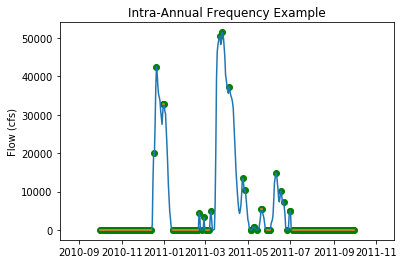

21

In [17]:
site_id = 11447650
start_date = '2009-10-01'
end_date = '2014-09-30'
selected_record = 'sample'
selected_sites = 'SRB_SJB'


daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
threshold = round(daily['flow_cfs'].quantile(0.9), 1) #90th percentile
FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in daily['flow_cfs']]
daily['flow_above_threshold_cfs'] = FlowAbvThresholdList

test = pd.DataFrame(daily['flow_above_threshold_cfs']['2010-10-01':'2011-09-30'])
#print(test)
#plt.plot(test)
#plt.show()

from scipy.signal import argrelextrema
n = 1
test['max'] = test.iloc[argrelextrema(test.values, np.greater_equal, order=n, mode='clip')[0]]

plt.scatter(test.index, test['max'], c='g')
plt.plot(test)
plt.ylabel('Flow (cfs)')
plt.title('Intra-Annual Frequency Example')
plt.savefig('results/figures/intra_ann_freq/'+selected_record+'_'+selected_sites+'_'+str(site_id)+'.png', bbox_inches="tight")
plt.show()

#peaksabv90pt = sum(1 for flow in list(daily.loc[daily['WY'] == year]['flow above 90pt_cfs']) if flow > 0)
peaksabv90pt = sum(1 for flow in list(test['max']) if flow > 0)
peaksabv90pt

In [ ]:
# center of mass and timing of hydrologic year

def day_of_peak(x):
    d = x.idxmax().dayofyear # get the date of the peak flow 
    # idxmax: return index of first occurrence of maximum over requested axis.
    return (d - 274 if d >= 274 else d + 91) # convert calendar day to water-year day
    # 365 - 31 - 30 - 30 = 365 - 91 = 274

peak_day = df.resample('AS-OCT').apply(day_of_peak)